## Read this

- https://s.id/PanduanPenggunaanDGXA100

## Import Libraries

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!pip install jupyter

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip uninstall traitlets --y
!pip install traitlets==5.9.0

Found existing installation: traitlets 5.9.0
Uninstalling traitlets-5.9.0:
  Successfully uninstalled traitlets-5.9.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 3.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from tqdm import tqdm

# from torchsummary import summary

## Download Model

In [3]:
tokenizer = AutoTokenizer.from_pretrained("StevenLimcorn/MelayuBERT")
model_class = AutoModel.from_pretrained("StevenLimcorn/MelayuBERT")

# Data collator is used for padding in batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at StevenLimcorn/MelayuBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Save Model to local - Example

In [ ]:
# save_path = 'model/'
# !mkdir -p model

# model_class_path = os.path.join(save_path, "indobert_class"+".pth")

# torch.save(model_class, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load Model - Example

In [4]:
# save_path = 'model/'
# model_class_path = os.path.join(save_path, "indobert_class"+".pth")

# bert_class = torch.load(model_class_path)

bert_class = model_class

In [5]:
print(bert_class)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

## Bert Test Simple Input

In [10]:
input = tokenizer("apa bedanya biru sama merah?")
print(input)
output = bert_class(torch.tensor(input['input_ids']).view(1, -1), return_dict=False)
output[0]

{'input_ids': [3, 1863, 12843, 1612, 6902, 2145, 2848, 35, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


tensor([[[-0.0613,  0.1456,  0.1383,  ...,  0.0249, -0.1513,  0.2291],
         [ 0.2091, -0.0023,  0.1980,  ...,  0.0334, -0.1403,  0.3982],
         [ 0.5372,  0.3916,  0.1318,  ..., -0.0403, -0.3527,  0.3249],
         ...,
         [ 0.6953,  0.2610,  0.2842,  ..., -0.0630, -0.1385,  0.2695],
         [ 0.3578,  0.2671,  0.1039,  ...,  0.0609, -0.2730, -0.0312],
         [ 0.1263,  0.3035,  0.2479,  ...,  0.0372, -0.1712,  0.1940]]],
       grad_fn=<NativeLayerNormBackward0>)

# Variables

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# LexID QA 2 Using BERT

## Dataset Class

In [7]:
class Lexidqa2Dataset(Dataset):
  """LexID QA2 Dataset"""

  def __init__(self, dataframe, tokenizer):
    """
      dataframe (Pandas DataFrame): Dataset in DataFrame format
      tokenizer (Tokenizer) : Sentence to Vector
    """
    self.qa_frame = dataframe
    self.tokenizer = tokenizer

    self.label2id = {"T1": 0, "T2": 1, "T3": 2, "T4": 3,
                "T5": 4, "T6": 5, "T7": 6, "T8": 7, "T9": 8,
                "T10": 9, "T11": 10, "T12": 11, "T13": 12,
                "T14": 13, "T15": 14, "T16": 15, "T17": 16, "T18": 17}
    self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
                4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
                9: "T10", 10: "T11", 11: "T12", 12: "T13",
                13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

  def __len__(self):
    return len(self.qa_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    question = self.qa_frame.loc[idx, "question"]
    question_tokenized = tokenizer(question, truncation=True)
    question_input_ids = torch.tensor(question_tokenized['input_ids'])
    question_token_type_ids = torch.tensor(question_tokenized['token_type_ids'])
    question_attention_masks = torch.tensor(question_tokenized['attention_mask'])

    answer = self.qa_frame.loc[idx, "answer"]
    template_label = self.qa_frame.loc[idx, "template_index"]

    template_id = self.one_hot(template_label, self.label2id)

    sample = (question,
              question_input_ids,
              question_token_type_ids,
              question_attention_masks,
              answer,
              template_label,
              template_id)

    return sample

  def one_hot(self, label, label2id):
    one_hot_label = torch.zeros(len(label2id))
    one_hot_label[label2id[label]] = 1

    return one_hot_label

## Merging Dataset from Different csv

In [ ]:
t1 = pd.read_csv("tesaurus/t1_dataset_tesaurus.csv")
num, _ = t1.shape
num

12155

In [ ]:
t = pd.DataFrame()
for i in range(1, 19):
  read_path = "tesaurus/t" + str(i) + "_dataset_tesaurus.csv"
  t_index = pd.read_csv(read_path)

  num_row, _ = t_index.shape
  two_thousands = np.min([2000, num_row])
  print("t" + str(i) + ": " + str(two_thousands))
  t = pd.concat([t, t_index[:two_thousands]], ignore_index=True)

t.head()

t1: 2000
t2: 2000
t3: 2000
t4: 2000
t5: 2000
t6: 2000
t7: 2000
t8: 2000
t9: 2000
t10: 2000
t11: 2000
t12: 2000
t13: 2000
t14: 314
t15: 955
t16: 2000
t17: 2000
t18: 2000


,question,answer,ner,legal_document,query,template_index,pasal_num,ayat_num
0,Peraturan Daerah Kota Semarang Nomor 6 Tahun 2...,H Sukawi Sutarip,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]",https://w3id.org/lex-id/data/Perkot_Semarang_2...,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
1,Pelegal dari Peraturan Presiden Republik Indon...,Joko Widodo,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]",https://w3id.org/lex-id/data/Perpres_2019_89,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
2,Peraturan Menteri Pertahanan Republik Indonesi...,Ryamizard Ryacudu,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]",https://w3id.org/lex-id/data/Permen_Han_2016_37,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
3,Keabsahan Peraturan Daerah Kabupaten Wakatobi ...,H U G U A,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",https://w3id.org/lex-id/data/Perkab_Wakatobi_2...,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN
4,Status Peraturan Pemerintah Republik Indonesia...,Dr Hamid Awaludin,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...",https://w3id.org/lex-id/data/PP_2005_6,\n SELECT DISTINCT ?answer\n WHERE {\n ...,T1,NaN,NaN


## Dataset

In [ ]:
qa_dataset = Lexidqa2Dataset(t, tokenizer)

## Sample from dataset

In [ ]:
np.random.seed(12345)
random_indices = np.random.choice(range(len(qa_dataset)), size=5, replace=False)

for i in random_indices:
  sample = qa_dataset[i]

  print(i, sample[0])

  if i == 5:
    break

5710 Kapan terjadinya pengukugannya Peraturan Menteri Keuangan Republik Indonesia Nomor 204 Tahun 2015 ini keluar
21038 Apakah isi Pasal 2 dalam Peraturan Menteri Kelautan Dan Perikanan Republik Indonesia Nomor 25 Tahun 2012 itu
19978 Berapa jumlah pasal yang tersusun di Peraturan Pemerintah Republik Indonesia Nomor 26 Tahun 2016 tersebut
29131 Sudahkah Peraturan Daerah Provinsi Jawa Tengah Nomor 16 Tahun 2002 tersebut dilakukan penyempurnaan
26026 Peraturan Komisi Pemilihan Umum Republik Indonesia Nomor 10 Tahun 2015 tersebut terjadi penganuliran pasal-pasal mana saja


In [ ]:
BATCH_SIZE = 64
torch.manual_seed(12345)

data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(train_idx)
test_size = len(test_idx)

NameError: name 'qa_dataset' is not defined

### Save train test data to CSV

In [13]:
# train_df = t.iloc[train_idx]
# !mkdir -p dataset
# train_df.to_csv('dataset/train_tesaurus.csv', index=False)

In [ ]:
# test_df = t.iloc[test_idx]
# !mkdir -p dataset
# test_df.to_csv('dataset/test_tesaurus.csv', index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Split, DataLoader

In [8]:
def collate_fn_class(data):
    """
       data: is a list of tuples with (example, label, length)
             where 'example' is a tensor of arbitrary shape
             and label/length are scalars
    """
    _, input_ids, _, _, _, _, label_ids = zip(*data)
    features = pad_sequence(input_ids, batch_first=True)
    targets = torch.stack(label_ids)
    return features, targets

### Prepare for KFold

### Load train test data

In [15]:
train_df = pd.read_csv('dataset/train_tesaurus.csv')
train_df['template_index'].value_counts()

T4     1500
T7     1500
T10    1500
T3     1500
T9     1500
T18    1500
T5     1500
T16    1500
T11    1500
T12    1500
T1     1500
T6     1500
T13    1500
T8     1500
T17    1500
T2     1500
T15     716
T14     235
Name: template_index, dtype: int64

In [16]:
test_df = pd.read_csv('dataset/test_tesaurus.csv')
test_df['template_index'].value_counts()

T17    500
T10    500
T13    500
T3     500
T2     500
T8     500
T11    500
T12    500
T4     500
T5     500
T9     500
T7     500
T18    500
T6     500
T1     500
T16    500
T15    239
T14     79
Name: template_index, dtype: int64

In [9]:
BATCH_SIZE = 64
torch.manual_seed(12345)

train_df = pd.read_csv('dataset/train_tesaurus.csv')
test_df = pd.read_csv('dataset/test_tesaurus.csv')

qa_dataset_train = Lexidqa2Dataset(train_df, tokenizer)
qa_dataset_test = Lexidqa2Dataset(test_df, tokenizer)

# data_all_label = [qa_dataset[i][5] for i in range(len(qa_dataset))]
# train_idx, test_idx = train_test_split(np.arange(len(qa_dataset)), test_size=0.25, random_state=12345, shuffle=True, stratify=data_all_label)

train_size = len(qa_dataset_train)
test_size = len(qa_dataset_test)

data_train_label = [qa_dataset_train[i][5] for i in range(train_size)]

# test_dataset = Subset(qa_dataset, test_idx)
test_instances = DataLoader(qa_dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

# Classification

## Model

### Loss Function

> Loss Function Multi-Class Classification: CrossEntropyLoss

In [10]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')

### Evaluation Function

In [11]:
def confusion_matrix(gold, pred, conf_matrix):
  _, gold = torch.max(gold, 1)
  _, pred = torch.max(pred, 1)
  for g, p in zip(gold.view(-1), pred.view(-1)):
    conf_matrix[g.long(), p.long()] += 1

  return conf_matrix

In [12]:
def evaluation_metric(conf_matrix):
  nb_classes = 18
  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']

  amt = amount(conf_matrix)
  # print(f"Debug Amount: {amt}")
  acc = accuracy(conf_matrix)
  prec = precision(conf_matrix)
  rec = recall(conf_matrix)
  f1 = fone(prec, rec)

  return amt, acc, prec, rec, f1

def amount(conf_matrix):
  return conf_matrix.sum(1)

def accuracy(conf_matrix):
  return conf_matrix.diag()/conf_matrix.sum(1)

def precision(conf_matrix):
  nb_classes = 18

  prec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_positive = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[col, index]
      else:
        false_positive += conf_matrix[col, index]
    prec[index] = true_positive / (true_positive + false_positive)

  return prec

def recall(conf_matrix):
  nb_classes = 18

  rec = torch.zeros(nb_classes)
  for index in range(nb_classes):
    true_positive = 0
    false_negative = 0
    for col in range(nb_classes):
      if index == col:
        true_positive = conf_matrix[index, col]
      else:
        false_negative += conf_matrix[index, col]
    rec[index] = true_positive / (true_positive + false_negative)

  return rec

def fone(prec, rec):
  nb_classes = 18

  f1 = torch.zeros(nb_classes)
  for index in range(nb_classes):
    f1[index] = 2 * (prec[index] * rec[index]) / (prec[index] + rec[index])

  return f1

### BERT + Full Connected Layer

In [13]:
class BERT_Lexidqa2_class(nn.Module):
    def __init__(self, bert, input_size = 768, output_size = 18):
        super().__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.ReLU()

        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, output_size)

        self.id2label = {0: "T1", 1: "T2", 2: "T3", 3: "T4",
              4: "T5", 5: "T6", 6: "T7", 7: "T8", 8: "T9",
              9: "T10", 10: "T11", 11: "T12", 12: "T13",
              13: "T14", 14: "T15", 15: "T16", 16: "T17", 17: "T18"}

    def forward(self, x):
        x, _ = self.bert(x, return_dict=False)

        # Only take the first column, Pooled Output, The Context
        x = x[:, 0, :]
        x = x.view(-1, 768)

        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.linear2(x)

        return x

    def predict(input):
      output = self.forward(torch.tensor(input['input_ids']).view(1, -1))

      id_max = torch.argmax(output)
      return self.id2label[id_max.item()]

In [14]:
model = BERT_Lexidqa2_class(bert_class, 768, 18)

## Training

> Train using 5-Fold
>
> Save checkpoint every 5 Epoch Max 20 Epoch

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 1 =====:=====:=====:=====:=====


Some weights of BertModel were not initialized from the model checkpoint at StevenLimcorn/MelayuBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
0it [00:07, ?it/s]

Fold 1 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:00, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.035434619703130395


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:14<04:27, 14.06s/it]

Average Loss Validation: 0.02104193938325436
Time 14.054050922393799

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.019513112614173926


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:27<04:07, 13.76s/it]

Average Loss Validation: 0.012001199023419309
Time 13.546049118041992

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.01280457926895432


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:41<03:51, 13.62s/it]

Average Loss Validation: 0.008115689134913059
Time 13.437440395355225

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.009654127216649676


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:54<03:37, 13.59s/it]

Average Loss Validation: 0.006478647482559978
Time 13.540989398956299

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.007959403953177178


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0052377437570725145
Time 13.504482507705688



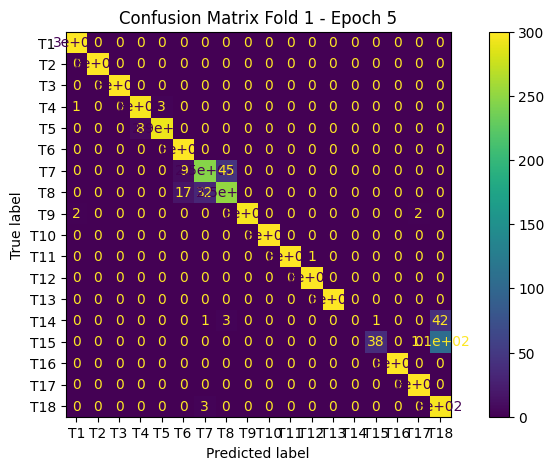

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,0.990099,1.000000,0.995025
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.986667,0.973684,0.986667,0.980132
T5,300.0,0.973333,0.989830,0.973333,0.981513
T6,300.0,1.000000,0.920245,1.000000,0.958466
T7,300.0,0.820000,0.872340,0.820000,0.845361
T8,300.0,0.836667,0.839465,0.836667,0.838063
T9,300.0,0.986667,1.000000,0.986667,0.993289
T10,300.0,1.000000,1.000000,1.000000,1.000000


 25%|███████████                                 | 5/20 [01:14<04:00, 16.03s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.006633918471111802


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:28<03:32, 15.19s/it]

Average Loss Validation: 0.0042625975660178115
Time 13.568652391433716

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005651879388995782


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:42<03:10, 14.67s/it]

Average Loss Validation: 0.0035298018124939037
Time 13.587996006011963

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004870145585768686


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:55<02:51, 14.30s/it]

Average Loss Validation: 0.0029264290391073223
Time 13.483279466629028

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004314846322985594


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:09<02:34, 14.03s/it]

Average Loss Validation: 0.002451049195659636
Time 13.446304559707642

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0038033226717688992


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.002128897144856087
Time 13.280117750167847



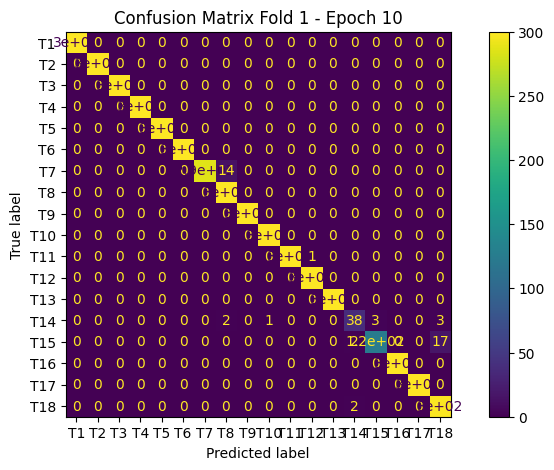

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,0.953333,1.000000,0.953333,0.976109
T8,300.0,1.000000,0.949367,1.000000,0.974026
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,0.996678,1.000000,0.998336


 50%|█████████████████████▌                     | 10/20 [02:28<02:37, 15.77s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003356503457099737


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:42<02:16, 15.11s/it]

Average Loss Validation: 0.0018181365525954186
Time 13.606887817382812

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0029970611115256868


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:55<01:56, 14.61s/it]

Average Loss Validation: 0.0016155357417924636
Time 13.437698125839233

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0026861517755445356


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:09<01:39, 14.24s/it]

Average Loss Validation: 0.0014305420621462275
Time 13.375144004821777

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002442491958235094


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:22<01:24, 14.00s/it]

Average Loss Validation: 0.0012626597731320278
Time 13.450888633728027

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002236512809514044


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.001157697577546723
Time 13.367866277694702



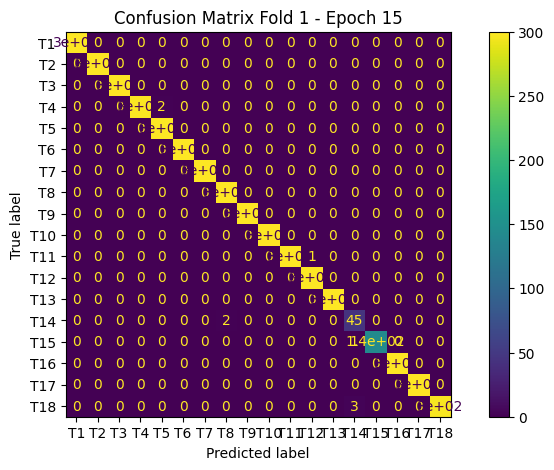

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.993333,1.000000,0.993333,0.996656
T5,300.0,1.000000,0.993378,1.000000,0.996678
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.993378,1.000000,0.996678
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [03:41<01:17, 15.40s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.0020731261899631344


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:54<00:59, 14.78s/it]

Average Loss Validation: 0.0010212587016877037
Time 13.312500715255737

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0018654812735790958


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:08<00:43, 14.37s/it]

Average Loss Validation: 0.0009403502159201294
Time 13.434387922286987

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017346590063077414


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:21<00:28, 14.12s/it]

Average Loss Validation: 0.0008598289849392233
Time 13.502496719360352

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0016706714324488908


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:35<00:14, 14.08s/it]

Average Loss Validation: 0.0007786801780149135
Time 14.004197835922241

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0014656495974811618


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0007126174338700847
Time 13.909563302993774



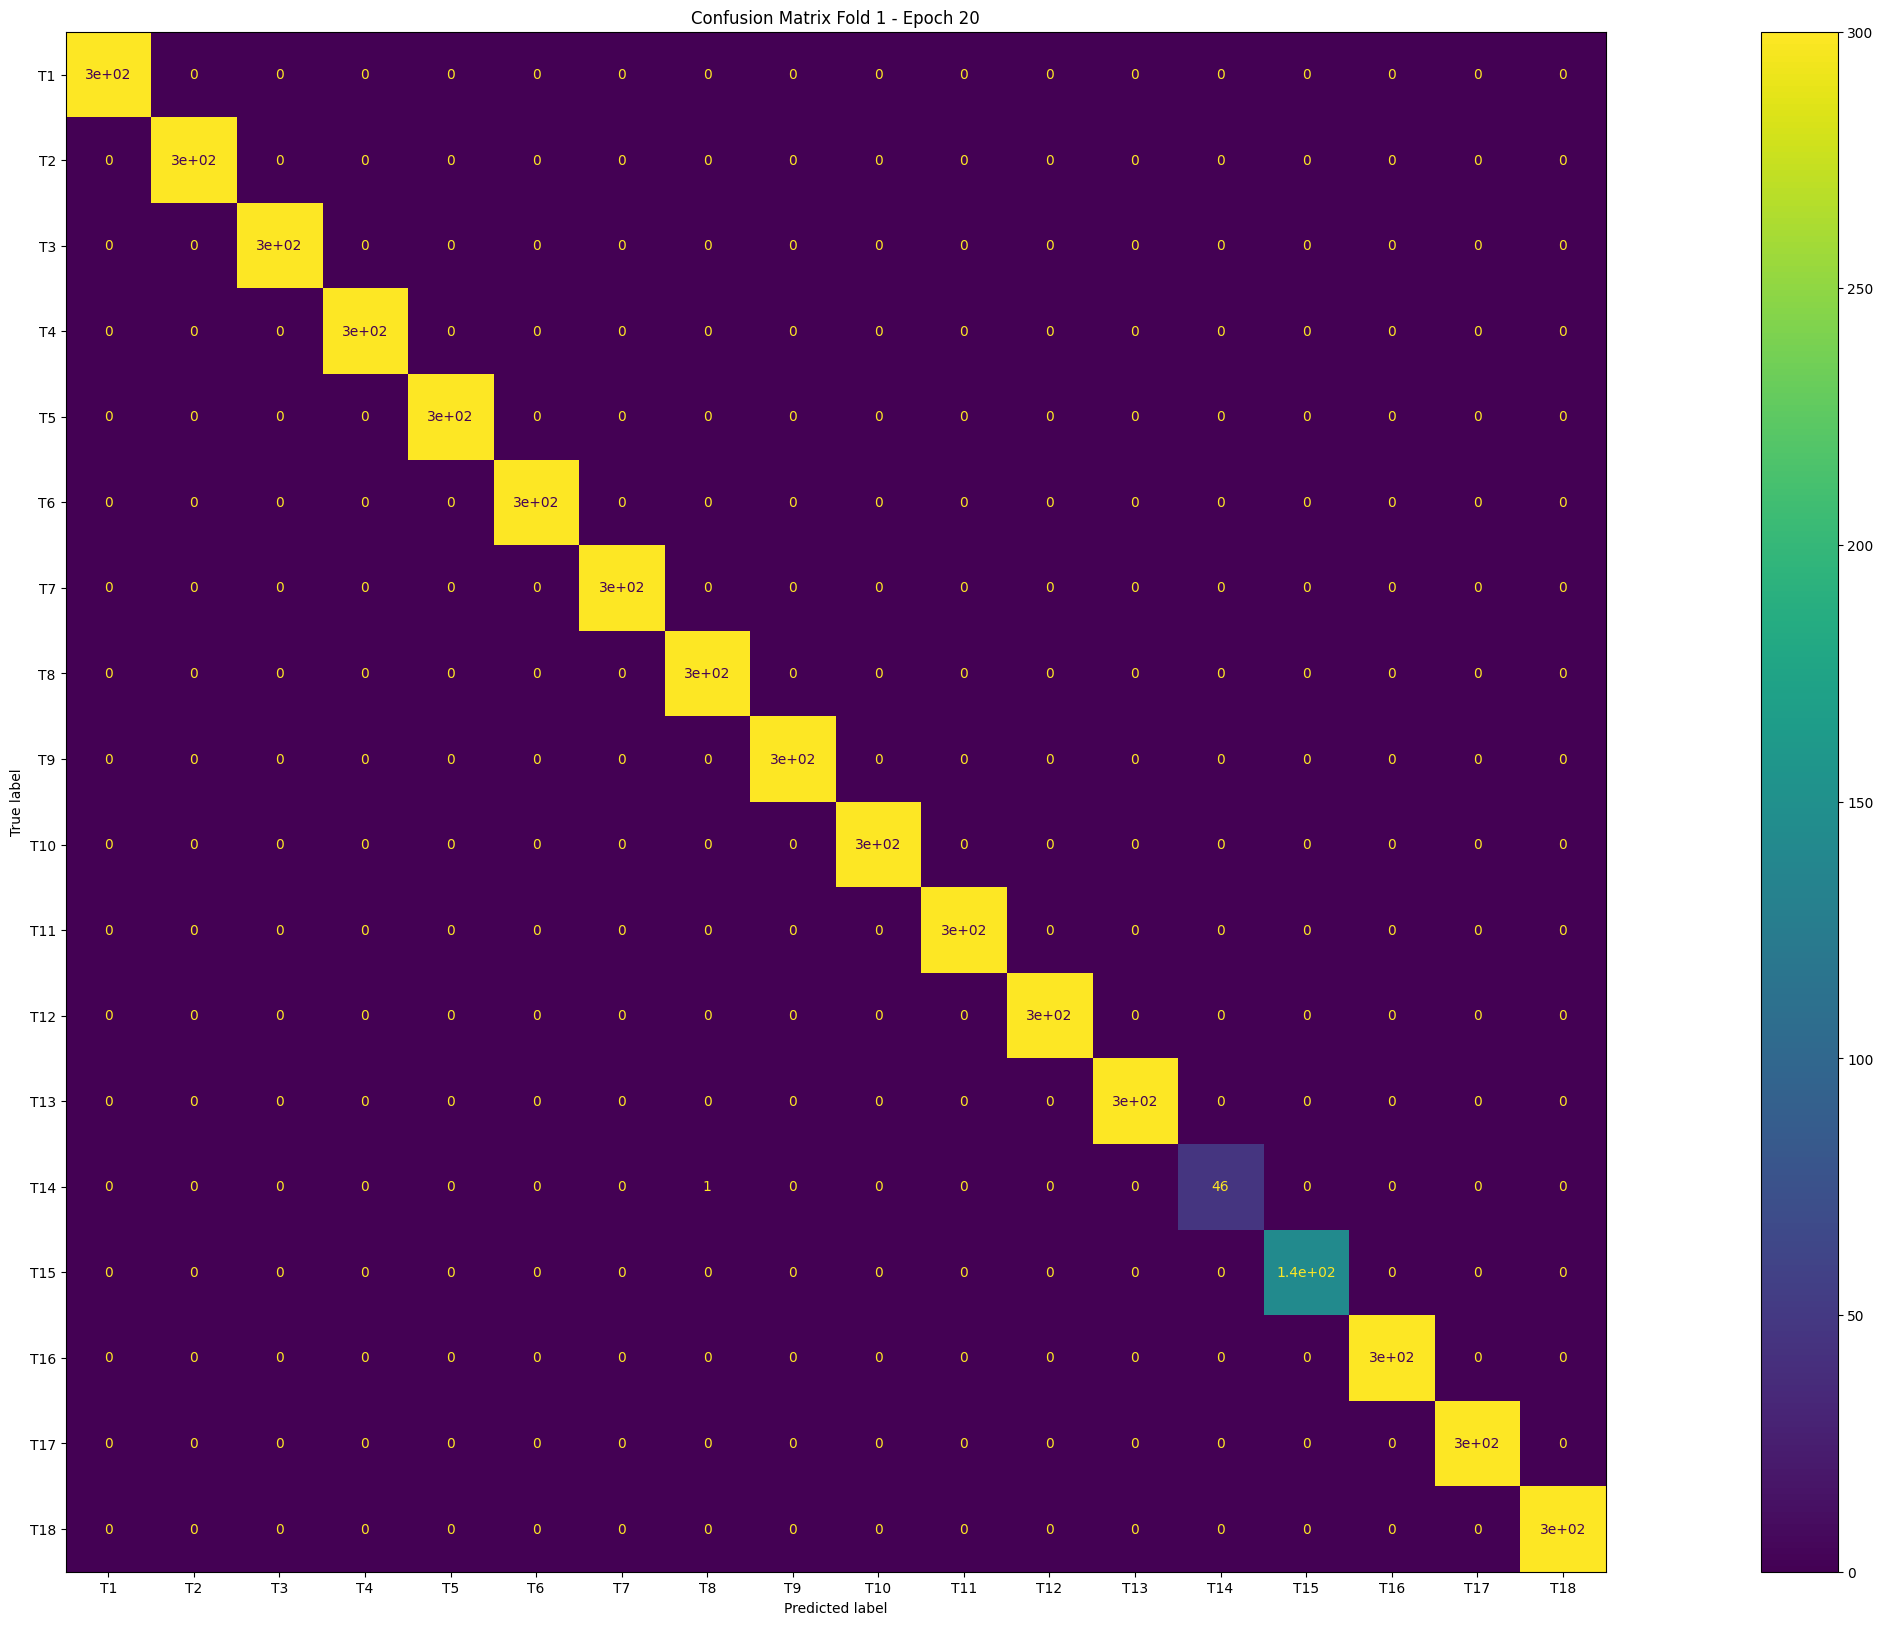

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,1.000000,1.000000,1.000000
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [04:55<00:00, 14.75s/it]
1it [05:02, 302.37s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 2 =====:=====:=====:=====:=====


Some weights of BertModel were not initialized from the model checkpoint at StevenLimcorn/MelayuBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
1it [05:09, 302.37s/it]

Fold 2 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03595267251834895


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:14<04:29, 14.18s/it]

Average Loss Validation: 0.021617366722924913
Time 14.169762134552002

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.019895125164619446


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:28<04:16, 14.26s/it]

Average Loss Validation: 0.01215949701163955
Time 14.304886817932129

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.013189287658301739


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:42<04:01, 14.19s/it]

Average Loss Validation: 0.008570756385464945
Time 14.09970736503601

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.010302101263546776


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:56<03:42, 13.93s/it]

Average Loss Validation: 0.006944070000925618
Time 13.524375677108765

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0086089627121429


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0056880130557593455
Time 13.536828994750977



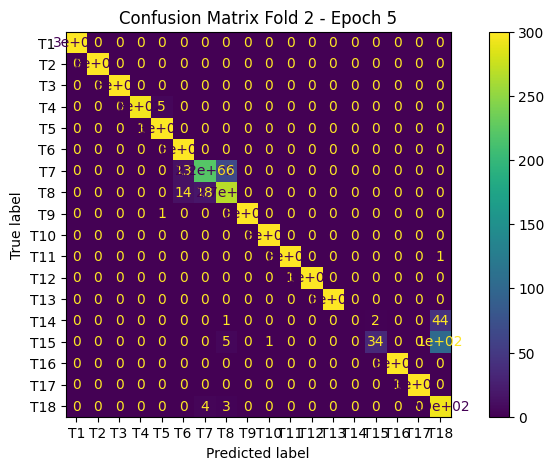

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.983333,0.996622,0.983333,0.989933
T5,300.0,0.996667,0.980328,0.996667,0.988430
T6,300.0,1.000000,0.917431,1.000000,0.956938
T7,300.0,0.736667,0.909465,0.736667,0.813996
T8,300.0,0.893333,0.781341,0.893333,0.833592
T9,300.0,0.996667,1.000000,0.996667,0.998331
T10,300.0,1.000000,0.996678,1.000000,0.998336


 25%|███████████                                 | 5/20 [01:14<03:54, 15.64s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0072968859996473635


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:28<03:28, 14.88s/it]

Average Loss Validation: 0.004664396764878519
Time 13.391670942306519

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.006264945657594512


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:41<03:07, 14.40s/it]

Average Loss Validation: 0.003880232402341877
Time 13.422220230102539

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005407448680539043


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:55<02:48, 14.07s/it]

Average Loss Validation: 0.003340682936813645
Time 13.36046051979065

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0047766615733087


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:08<02:32, 13.90s/it]

Average Loss Validation: 0.002772889099641888
Time 13.487947225570679

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004201166153724504


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0023749071096848392
Time 13.455575942993164



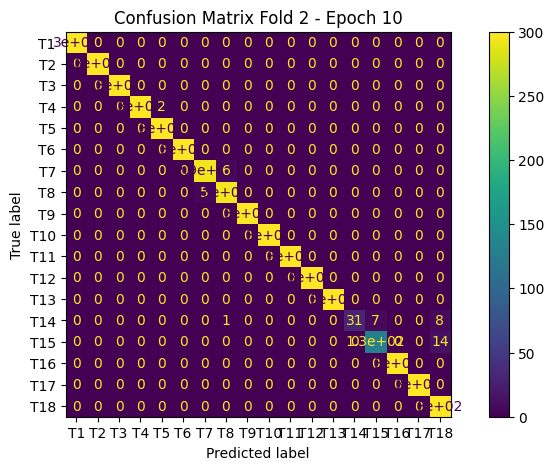

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.993333,1.000000,0.993333,0.996656
T5,300.0,1.000000,0.993378,1.000000,0.996678
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,0.980000,0.983278,0.980000,0.981636
T8,300.0,0.983333,0.976821,0.983333,0.980066
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [02:27<02:33, 15.35s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0036947927933454476


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:40<02:13, 14.80s/it]

Average Loss Validation: 0.002020790892278025
Time 13.517645120620728

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0033441538813357707


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:54<01:55, 14.47s/it]

Average Loss Validation: 0.001780450375440842
Time 13.7197847366333

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0030472275153542263


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:08<01:39, 14.23s/it]

Average Loss Validation: 0.0015878909814333868
Time 13.682403564453125

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002755828654904636


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:21<01:24, 14.01s/it]

Average Loss Validation: 0.0014740421546843344
Time 13.497391700744629

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0024845981719880737


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0012477771358523435
Time 13.465252876281738



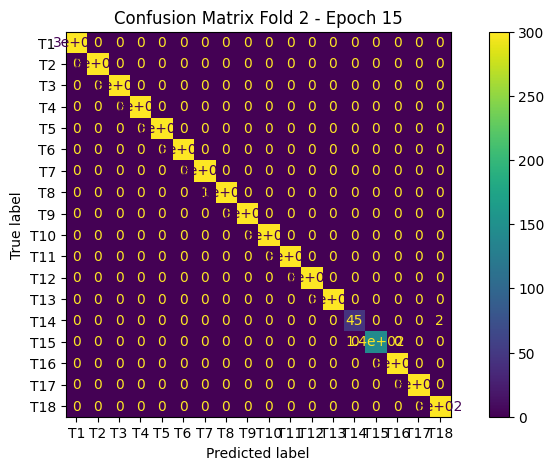

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,0.996678,1.000000,0.998336
T8,300.0,0.996667,1.000000,0.996667,0.998331
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [03:40<01:16, 15.35s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002340954911087135


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:53<00:59, 14.78s/it]

Average Loss Validation: 0.001127176731824875
Time 13.46801495552063

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021244030342981862


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:06<00:43, 14.38s/it]

Average Loss Validation: 0.0010454478813615256
Time 13.422804355621338

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0019299399607298961


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:20<00:28, 14.11s/it]

Average Loss Validation: 0.0009414864916779951
Time 13.482189416885376

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0018030243607222165


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:33<00:13, 13.93s/it]

Average Loss Validation: 0.000882836397670075
Time 13.51517939567566

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001704042269136533


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0007946711347134176
Time 13.335145950317383



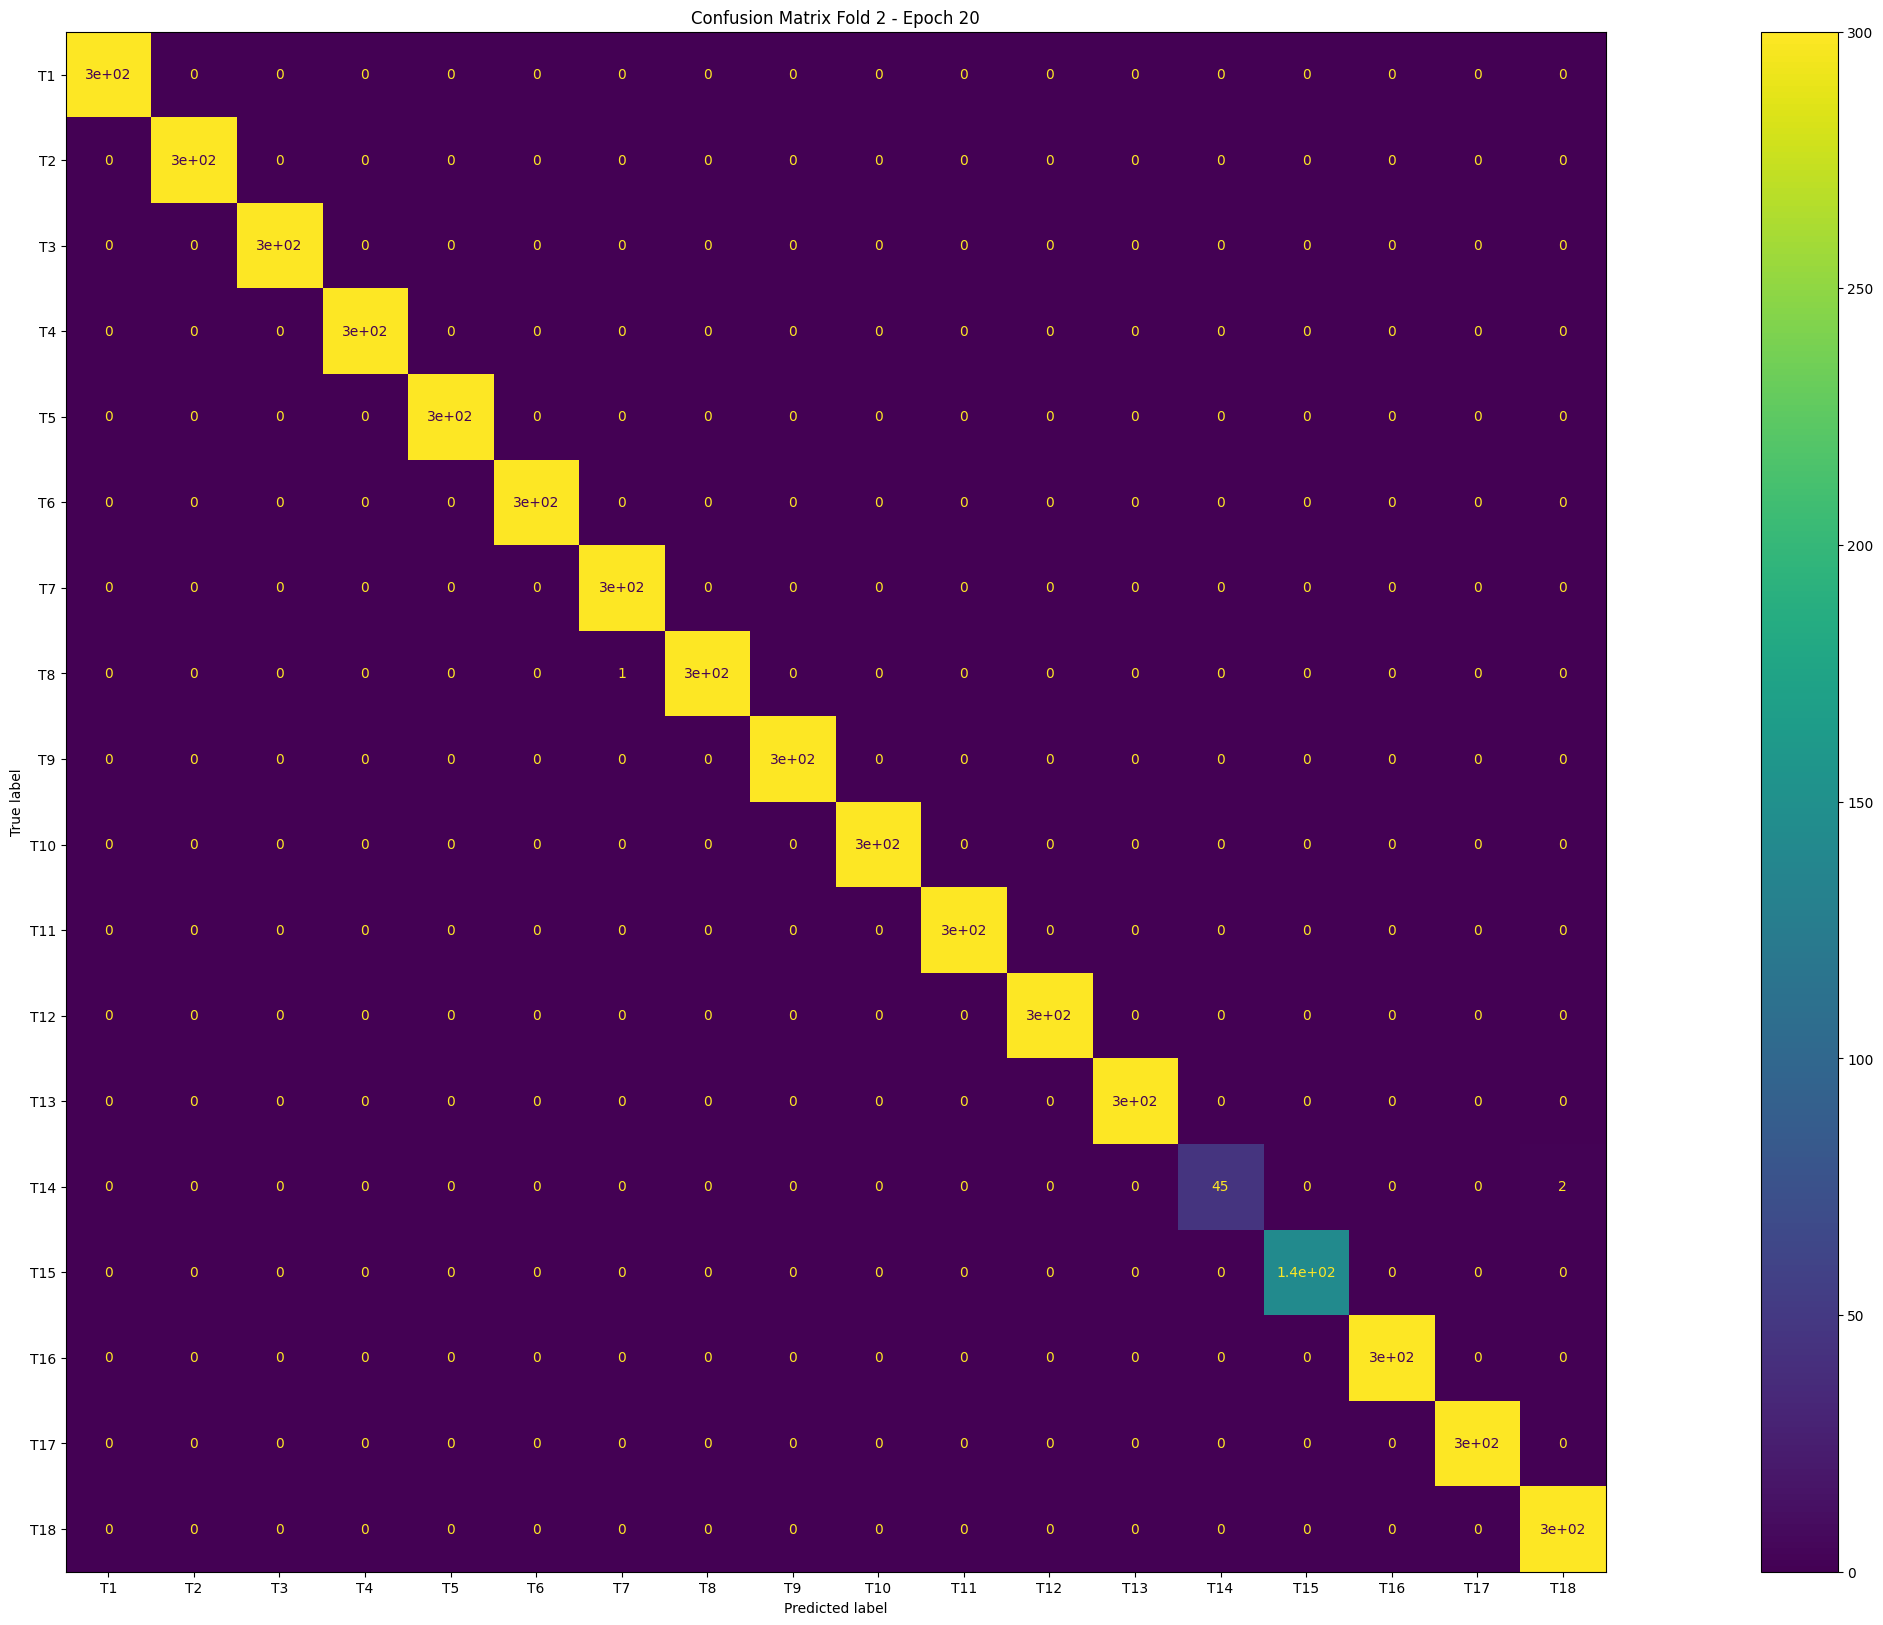

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,0.996678,1.000000,0.998336
T8,300.0,0.996667,1.000000,0.996667,0.998331
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [04:52<00:00, 14.63s/it]
2it [10:01, 300.49s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 3 =====:=====:=====:=====:=====


Some weights of BertModel were not initialized from the model checkpoint at StevenLimcorn/MelayuBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2it [10:08, 300.49s/it]

Fold 3 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.036371439027974975


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:16, 13.50s/it]

Average Loss Validation: 0.021573343281755468
Time 13.4932222366333

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.019375012794768103


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<04:02, 13.44s/it]

Average Loss Validation: 0.011566356200732306
Time 13.39771842956543

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.012716277138598367


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:40<03:49, 13.48s/it]

Average Loss Validation: 0.008276792381235019
Time 13.504216194152832

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00989304276525804


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:53<03:35, 13.49s/it]

Average Loss Validation: 0.0066947481257165365
Time 13.494798421859741

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.008141547414608048


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.005335688256548498
Time 13.443734645843506



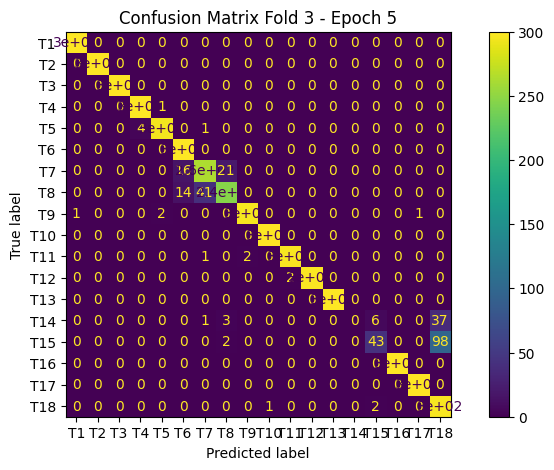

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,0.996678,1.000000,0.998336
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.996667,0.986799,0.996667,0.991708
T5,300.0,0.983333,0.989933,0.983333,0.986622
T6,300.0,1.000000,0.909091,1.000000,0.952381
T7,300.0,0.876667,0.856678,0.876667,0.866557
T8,300.0,0.816667,0.904059,0.816667,0.858144
T9,300.0,0.986667,0.993289,0.986667,0.989967
T10,300.0,1.000000,0.996678,1.000000,0.998336


 25%|███████████                                 | 5/20 [01:12<03:49, 15.32s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00691907125373121


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:25<03:25, 14.67s/it]

Average Loss Validation: 0.004437775127515048
Time 13.389201164245605

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.005885902000724132


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:39<03:05, 14.26s/it]

Average Loss Validation: 0.003723467507199916
Time 13.427370309829712

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00519330021936235


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:52<02:47, 13.99s/it]

Average Loss Validation: 0.0031527400016784666
Time 13.39351224899292

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004573739727300331


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:06<02:32, 13.82s/it]

Average Loss Validation: 0.0026549283362820534
Time 13.433841705322266

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004079876225808419


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0023149829768465613
Time 13.462701082229614



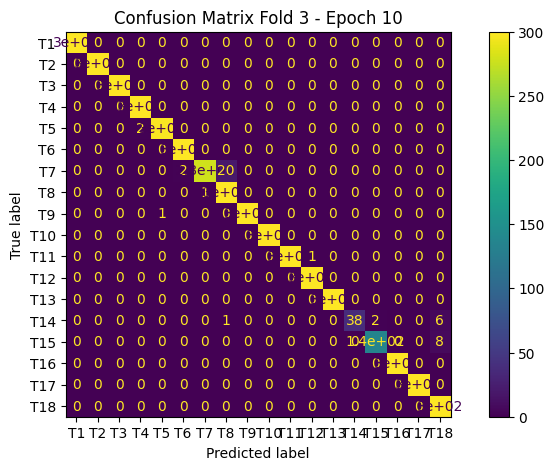

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,0.993378,1.000000,0.996678
T5,300.0,0.993333,0.996656,0.993333,0.994992
T6,300.0,1.000000,0.993378,1.000000,0.996678
T7,300.0,0.926667,0.996416,0.926667,0.960276
T8,300.0,0.996667,0.934375,0.996667,0.964516
T9,300.0,0.996667,1.000000,0.996667,0.998331
T10,300.0,1.000000,1.000000,1.000000,1.000000


 50%|█████████████████████▌                     | 10/20 [02:24<02:33, 15.31s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.003673049257965092


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:38<02:13, 14.78s/it]

Average Loss Validation: 0.002022358401863274
Time 13.583217859268188

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0032731986956285584


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:51<01:55, 14.40s/it]

Average Loss Validation: 0.0018897560382176019
Time 13.52445912361145

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0029390552182646914


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:05<01:39, 14.16s/it]

Average Loss Validation: 0.0015856746009332622
Time 13.582096099853516

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002691477900707353


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:19<01:23, 13.97s/it]

Average Loss Validation: 0.0014494935397753018
Time 13.51926040649414

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002458830848302627


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0012815147548734783
Time 13.539304971694946



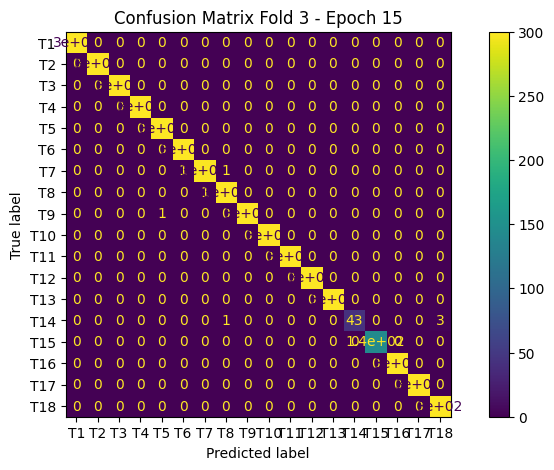

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,0.996678,1.000000,0.998336
T6,300.0,1.000000,0.996678,1.000000,0.998336
T7,300.0,0.993333,0.996656,0.993333,0.994992
T8,300.0,0.996667,0.993355,0.996667,0.995008
T9,300.0,0.996667,1.000000,0.996667,0.998331
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [03:37<01:16, 15.39s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002273939332314182


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:51<00:59, 14.79s/it]

Average Loss Validation: 0.0011877309105439273
Time 13.406733751296997

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0021128740411179557


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:04<00:43, 14.50s/it]

Average Loss Validation: 0.0010864306129291206
Time 13.806016445159912

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0019203721678189504


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:19<00:28, 14.41s/it]

Average Loss Validation: 0.000987999412960901
Time 14.190603733062744

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.001837992199266562


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:33<00:14, 14.29s/it]

Average Loss Validation: 0.0009173006371768538
Time 13.997611045837402

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017024684497883799


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0008428171919080203
Time 13.94823956489563



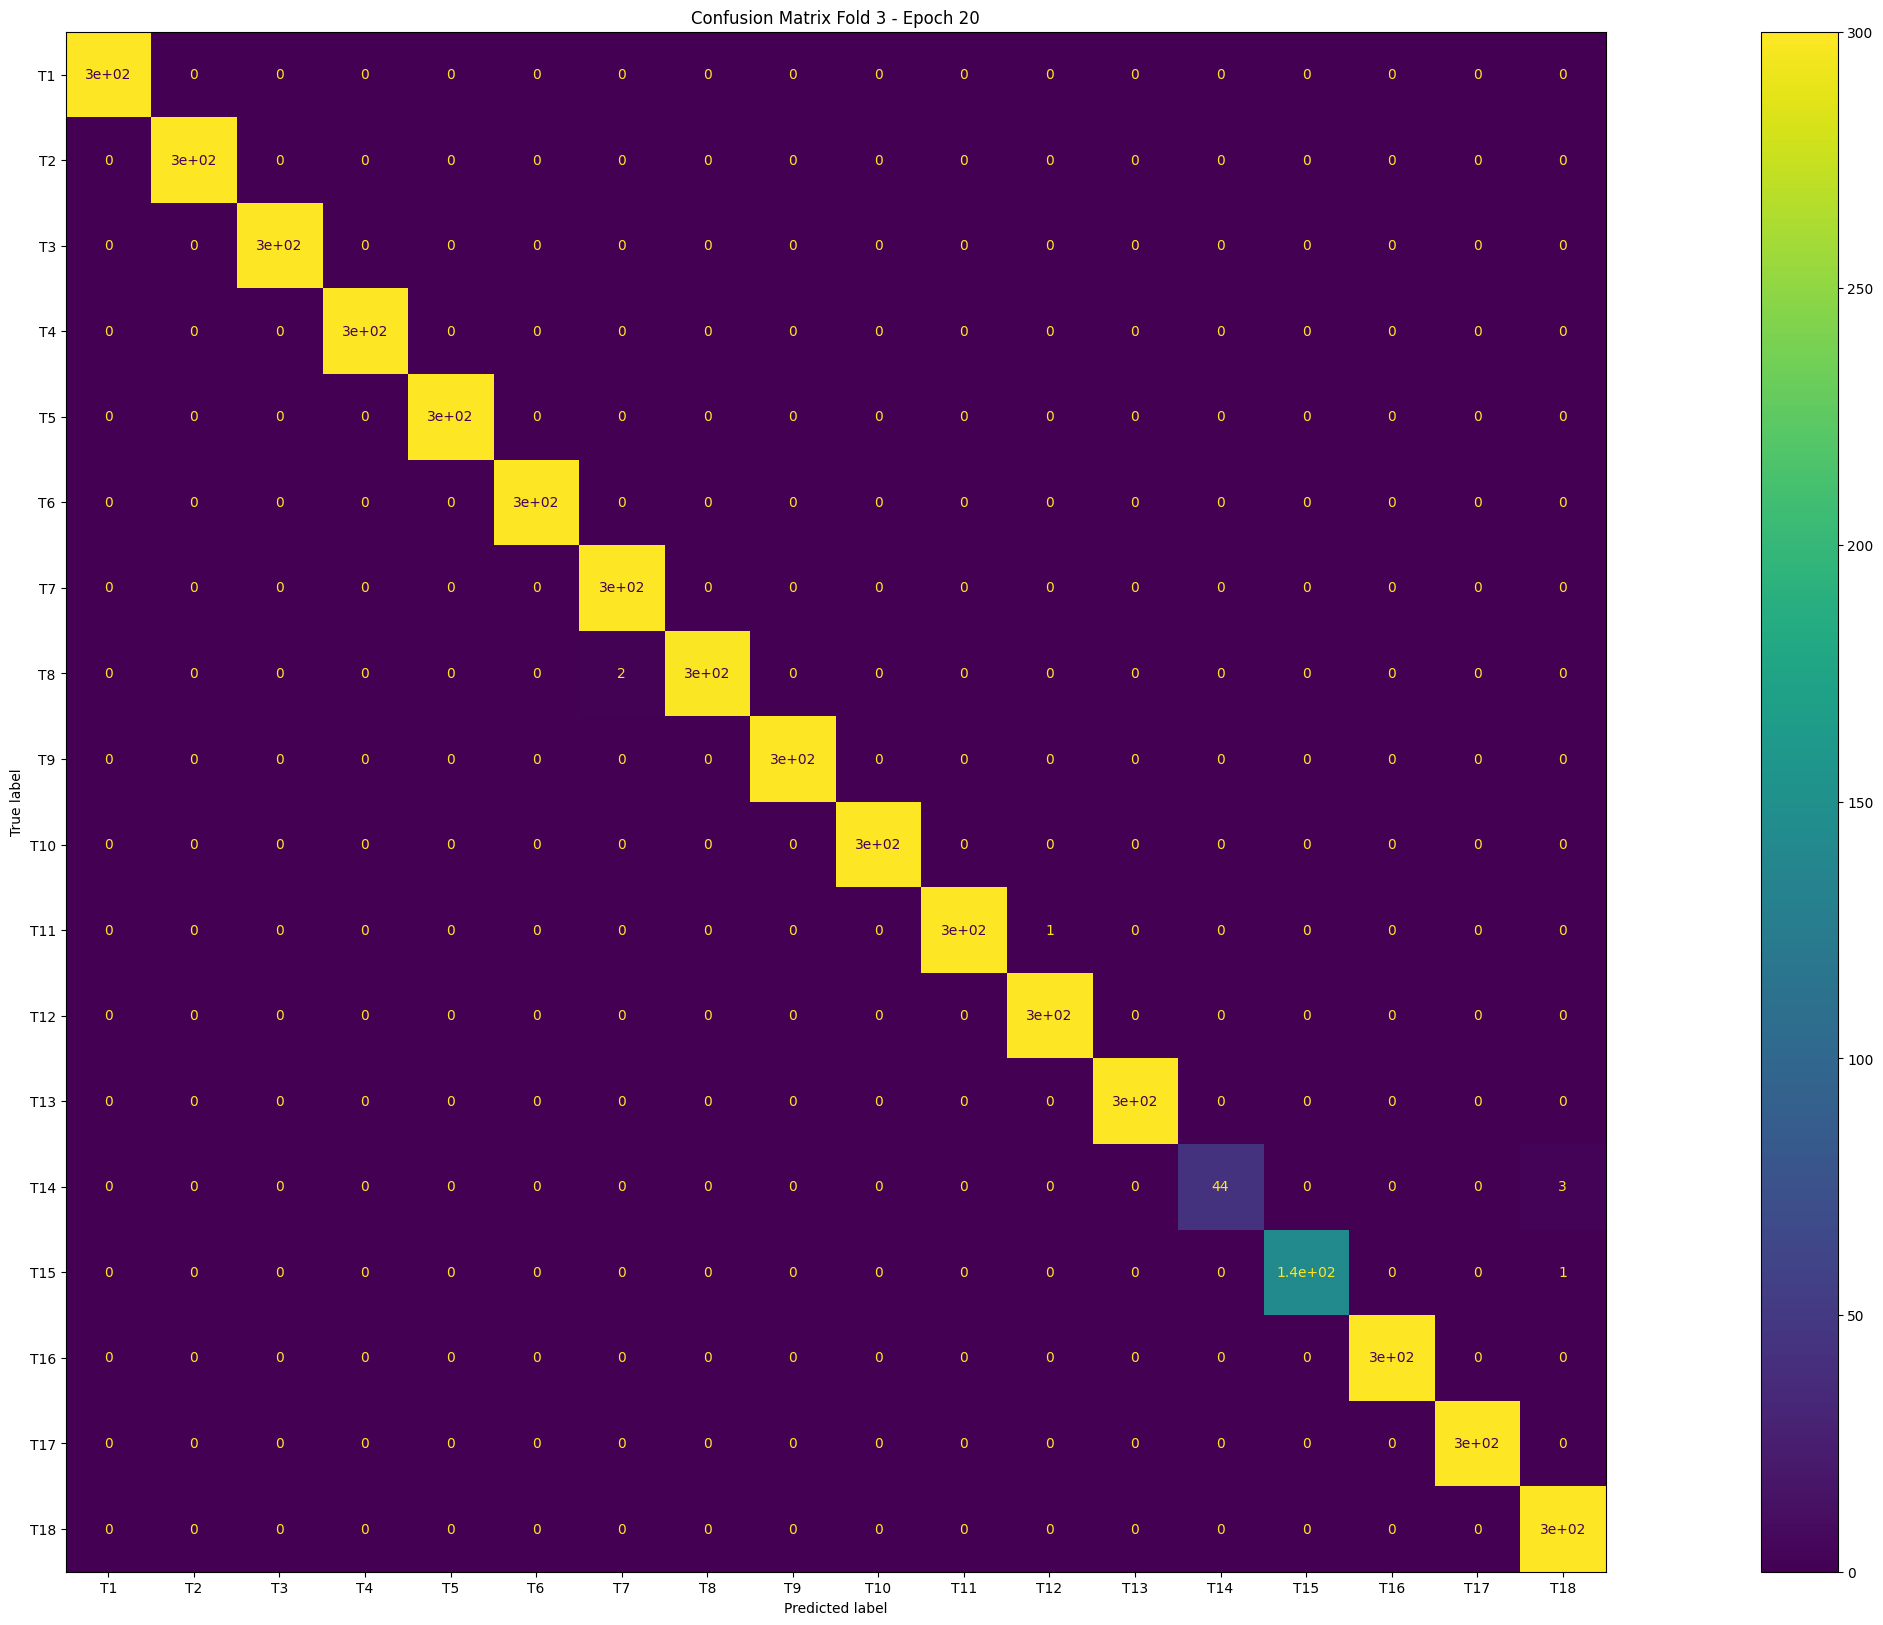

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,1.000000,1.000000,1.000000
T7,300.0,1.000000,0.993378,1.000000,0.996678
T8,300.0,0.993333,1.000000,0.993333,0.996656
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [04:52<00:00, 14.64s/it]
3it [15:01, 300.28s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 4 =====:=====:=====:=====:=====


Some weights of BertModel were not initialized from the model checkpoint at StevenLimcorn/MelayuBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
3it [15:07, 300.28s/it]

Fold 4 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03606590419749412


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:20, 13.71s/it]

Average Loss Validation: 0.021185471180206788
Time 13.697951555252075

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.019464213231433925


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:27<04:10, 13.91s/it]

Average Loss Validation: 0.011672134867650952
Time 14.036662340164185

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.012882720700880252


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:41<03:57, 13.98s/it]

Average Loss Validation: 0.008299185081808744
Time 14.065782308578491

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.010048356161203075


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:55<03:44, 14.02s/it]

Average Loss Validation: 0.006772130315671703
Time 14.075811386108398

Epoch 5 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0084282776649619


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0054693117289839385
Time 13.996956586837769



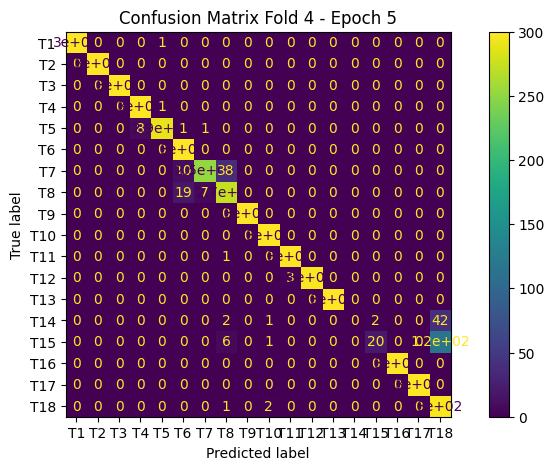

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,0.996667,1.000000,0.996667,0.998331
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.996667,0.973941,0.996667,0.985173
T5,300.0,0.966667,0.993151,0.966667,0.979730
T6,300.0,1.000000,0.909091,1.000000,0.952381
T7,300.0,0.840000,0.969231,0.840000,0.900000
T8,300.0,0.913333,0.850932,0.913333,0.881029
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,0.986842,1.000000,0.993377


 25%|███████████                                 | 5/20 [01:15<03:58, 15.92s/it]

Epoch 6 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.007112458128052671


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 30%|█████████████▏                              | 6/20 [01:29<03:33, 15.26s/it]

Average Loss Validation: 0.00441770826527972
Time 13.979370832443237

Epoch 7 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.006027157660160339


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 35%|███████████████▍                            | 7/20 [01:43<03:12, 14.84s/it]

Average Loss Validation: 0.003803759887963832
Time 13.9520742893219

Epoch 8 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0053052568515098006


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 40%|█████████████████▌                          | 8/20 [01:56<02:52, 14.37s/it]

Average Loss Validation: 0.0031645883270399367
Time 13.363764762878418

Epoch 9 / 20


==:==:==Train==:==:==: 0it [00:10, ?it/s]


Average Loss Train: 0.004649615830944175


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 45%|███████████████████▊                        | 9/20 [02:09<02:34, 14.02s/it]

Average Loss Validation: 0.002808851530711971
Time 13.234314918518066

Epoch 10 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.004189203348333459


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.002465216834881979
Time 13.3878915309906



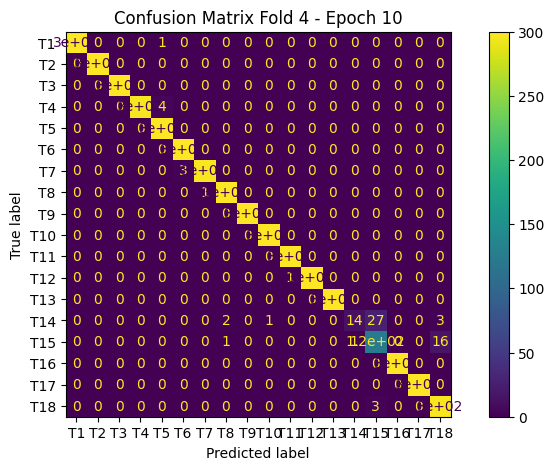

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,0.996667,1.000000,0.996667,0.998331
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,0.986667,1.000000,0.986667,0.993289
T5,300.0,1.000000,0.983607,1.000000,0.991736
T6,300.0,1.000000,0.990099,1.000000,0.995025
T7,300.0,0.990000,0.996644,0.990000,0.993311
T8,300.0,0.996667,0.990066,0.996667,0.993356
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,0.996678,1.000000,0.998336


 50%|█████████████████████▌                     | 10/20 [02:28<02:35, 15.51s/it]

Epoch 11 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0037554872728147786


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 55%|███████████████████████▋                   | 11/20 [02:42<02:14, 14.91s/it]

Average Loss Validation: 0.0021758985483574726
Time 13.546311616897583

Epoch 12 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0033526165113857112


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 60%|█████████████████████████▊                 | 12/20 [02:55<01:55, 14.48s/it]

Average Loss Validation: 0.0019203350201756778
Time 13.467061519622803

Epoch 13 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0030477994546330794


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 65%|███████████████████████████▉               | 13/20 [03:09<01:39, 14.16s/it]

Average Loss Validation: 0.0017141927489059004
Time 13.415081977844238

Epoch 14 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002830839839492722


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 70%|██████████████████████████████             | 14/20 [03:22<01:23, 13.96s/it]

Average Loss Validation: 0.0015354808307960182
Time 13.492102146148682

Epoch 15 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.002547567133691852


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0013621289036675301
Time 13.326513528823853



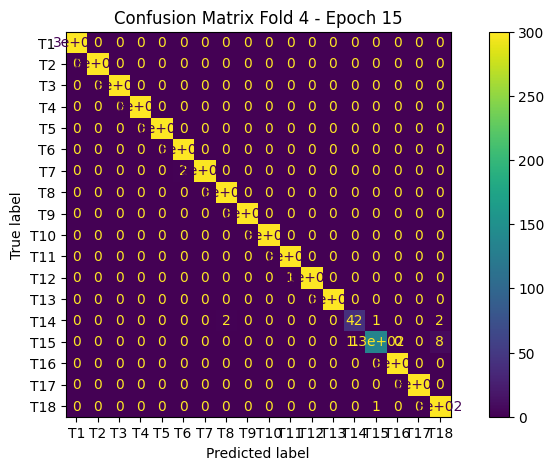

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,0.993378,1.000000,0.996678
T7,300.0,0.993333,1.000000,0.993333,0.996656
T8,300.0,1.000000,0.993378,1.000000,0.996678
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


 75%|████████████████████████████████▎          | 15/20 [03:41<01:16, 15.32s/it]

Epoch 16 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0023622400836586016


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 80%|██████████████████████████████████▍        | 16/20 [03:54<00:58, 14.75s/it]

Average Loss Validation: 0.0012257396435749555
Time 13.420984506607056

Epoch 17 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0022019746375402834


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 85%|████████████████████████████████████▌      | 17/20 [04:07<00:43, 14.36s/it]

Average Loss Validation: 0.0011714469895274463
Time 13.436883687973022

Epoch 18 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0019866669050653788


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 90%|██████████████████████████████████████▋    | 18/20 [04:21<00:28, 14.07s/it]

Average Loss Validation: 0.0010173810142015886
Time 13.397958040237427

Epoch 19 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0018633999955790905


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 95%|████████████████████████████████████████▊  | 19/20 [04:34<00:13, 13.89s/it]

Average Loss Validation: 0.0009406002973745724
Time 13.453012228012085

Epoch 20 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.0017051439278619417


==:==:==Valid==:==:==: 0it [00:02, ?it/s]


Average Loss Validation: 0.0008342068679705411
Time 13.443021535873413



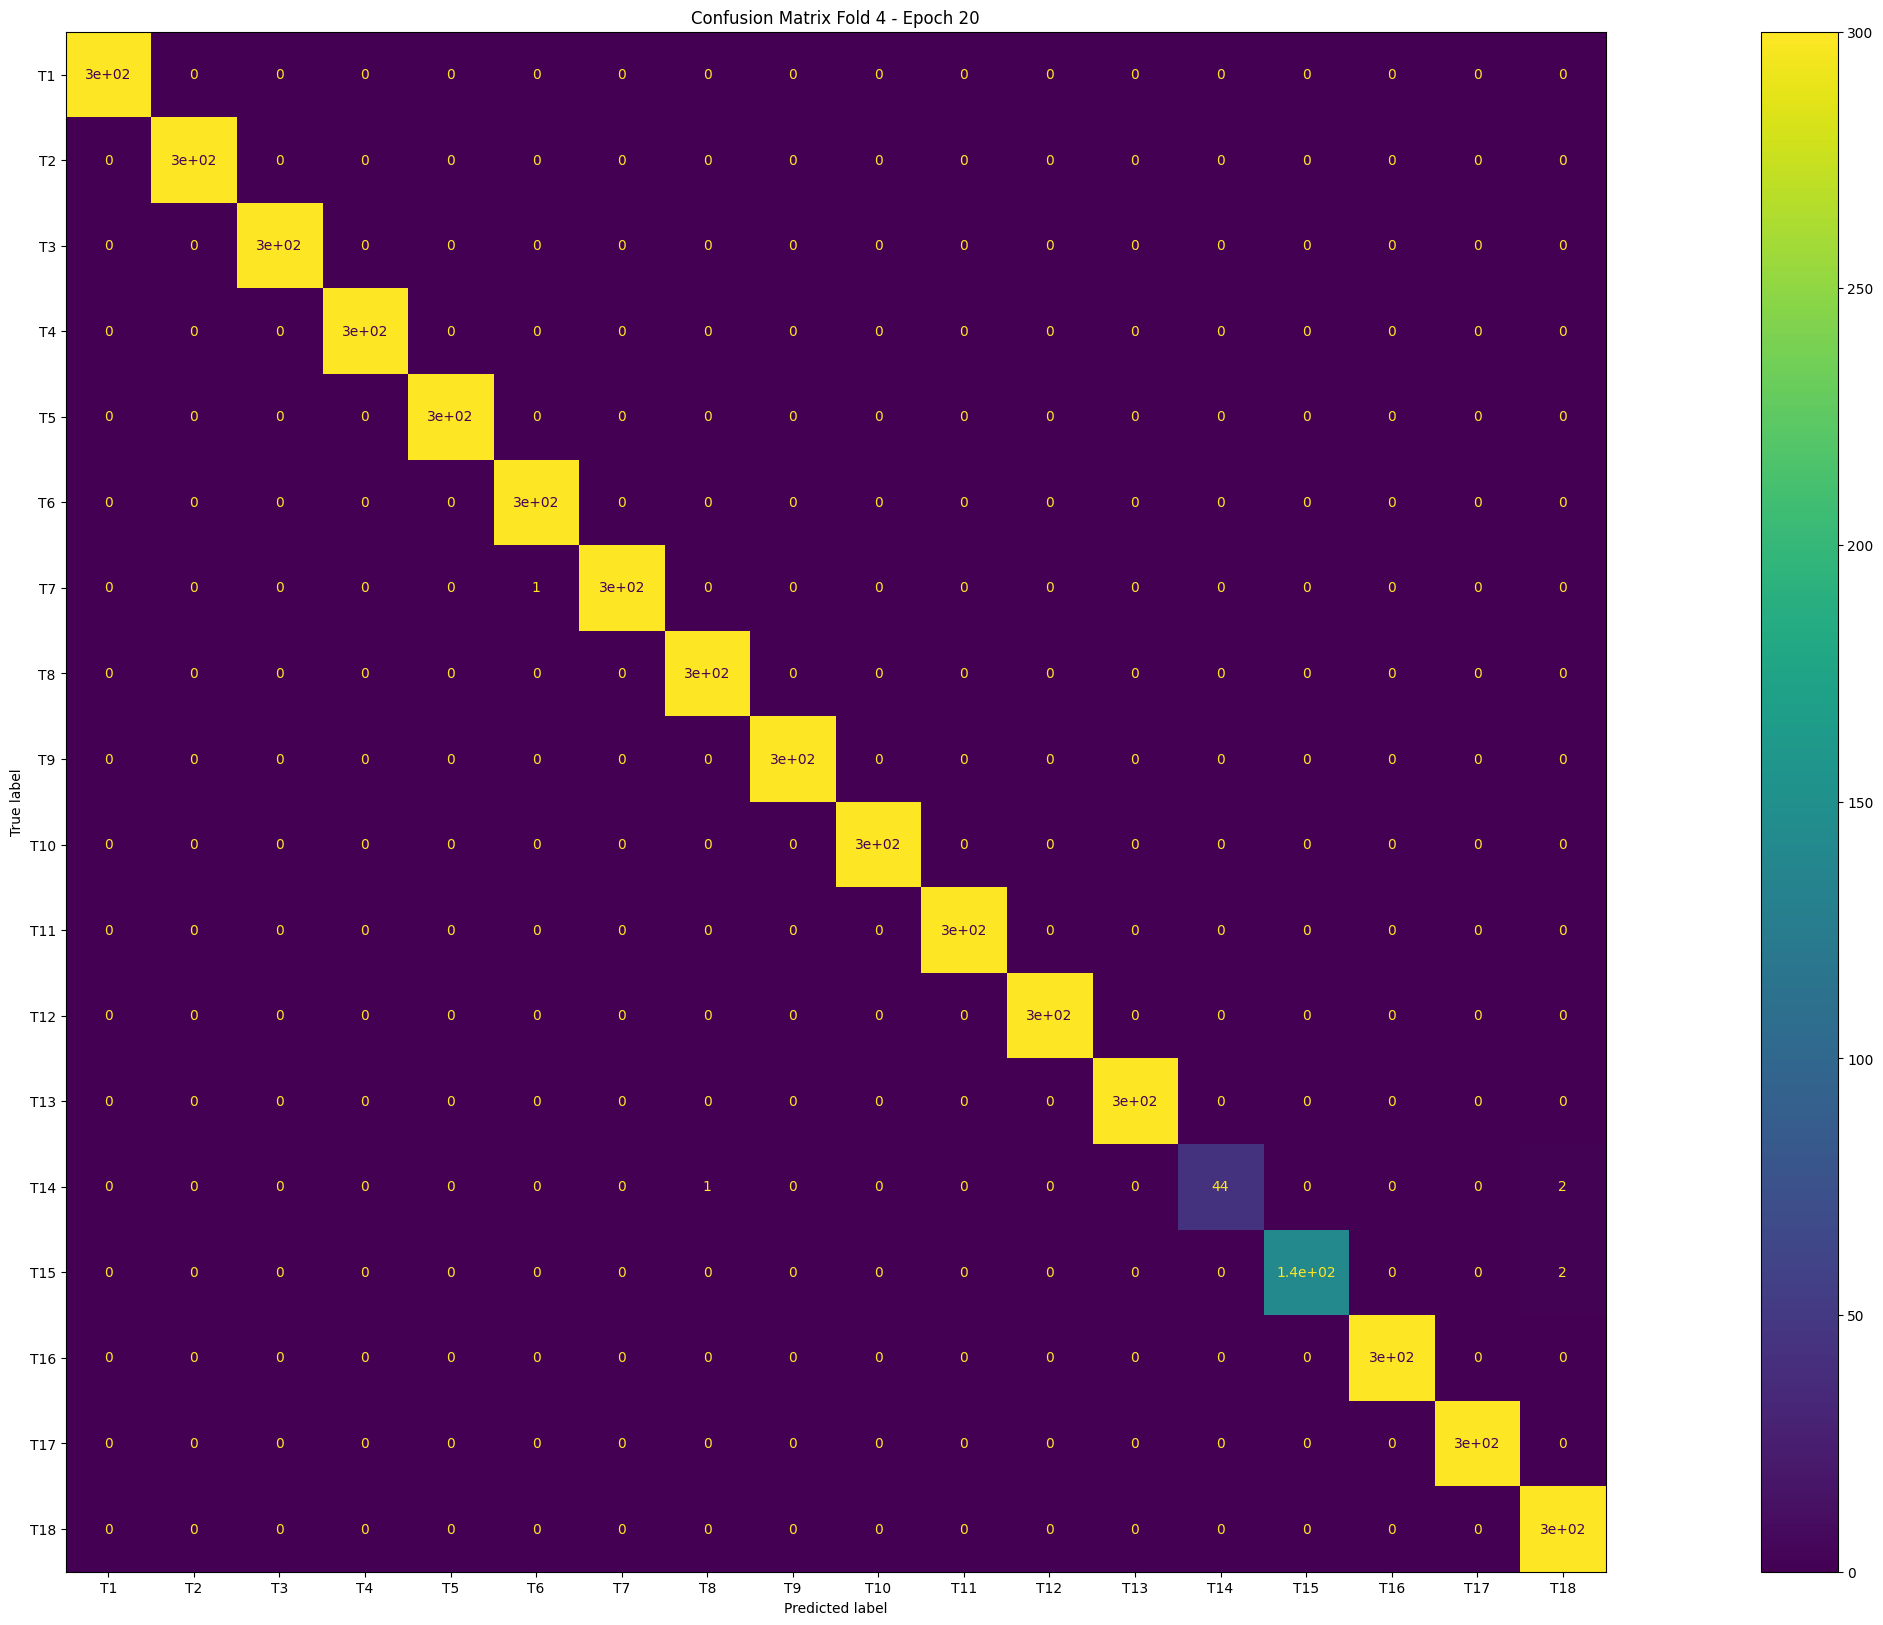

,Amount of Data,Accuracy,Precision,Recall,F One
T1,300.0,1.000000,1.000000,1.000000,1.000000
T2,300.0,1.000000,1.000000,1.000000,1.000000
T3,300.0,1.000000,1.000000,1.000000,1.000000
T4,300.0,1.000000,1.000000,1.000000,1.000000
T5,300.0,1.000000,1.000000,1.000000,1.000000
T6,300.0,1.000000,0.996678,1.000000,0.998336
T7,300.0,0.996667,1.000000,0.996667,0.998331
T8,300.0,1.000000,0.996678,1.000000,0.998336
T9,300.0,1.000000,1.000000,1.000000,1.000000
T10,300.0,1.000000,1.000000,1.000000,1.000000


100%|███████████████████████████████████████████| 20/20 [04:53<00:00, 14.68s/it]
4it [20:01, 299.96s/it]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


=====:=====:=====:=====:===== Fold 5 =====:=====:=====:=====:=====


Some weights of BertModel were not initialized from the model checkpoint at StevenLimcorn/MelayuBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
4it [20:06, 299.96s/it]

Fold 5 Ready


  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.03633378830183473


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
  5%|██▏                                         | 1/20 [00:13<04:16, 13.51s/it]

Average Loss Validation: 0.021272420262048144
Time 13.507384777069092

Epoch 2 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.01962940621594617


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 10%|████▍                                       | 2/20 [00:26<04:01, 13.44s/it]

Average Loss Validation: 0.011668224516278039
Time 13.387014627456665

Epoch 3 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.012941094771468755


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 15%|██████▌                                     | 3/20 [00:40<03:48, 13.44s/it]

Average Loss Validation: 0.008161054966683855
Time 13.428279638290405

Epoch 4 / 20


==:==:==Train==:==:==: 0it [00:11, ?it/s]


Average Loss Train: 0.00997175728293532


==:==:==Valid==:==:==: 0it [00:02, ?it/s]
 20%|████████▊                                   | 4/20 [00:53<03:36, 13.52s/it]

Average Loss Validation: 0.006555943701692478
Time 13.62398362159729

Epoch 5 / 20


In [ ]:
import time
torch.manual_seed(12345)

# training image classification

LEARNING_RATE = 5e-5
EPOCH = 20

model.to(DEVICE)

training_losses = [[] for i in range(5)]
validation_losses = [[] for i in range(5)]

skf = StratifiedKFold(n_splits=5)

# Load before training + validing
for fold_i, (train_index, val_index) in enumerate(tqdm(skf.split(np.zeros(len(qa_dataset_train)), data_train_label), position=0, leave=True)):
  tqdm.write(f"=====:=====:=====:=====:===== Fold {fold_i + 1} =====:=====:=====:=====:=====")

  # Subset dataset for train and val
  train_dataset = Subset(qa_dataset_train, train_index)
  valid_dataset = Subset(qa_dataset_train, val_index)

  train_size = len(train_dataset)
  valid_size = len(valid_dataset)

  train_instances = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_class)
  valid_instances = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_class)

  model_class = AutoModel.from_pretrained("StevenLimcorn/MelayuBERT")
  bert_class = model_class
  model = BERT_Lexidqa2_class(bert_class, 768, 18)
  model.to(DEVICE)

  # optimizer
  optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

  tqdm.write(f'Fold {fold_i + 1} Ready')

  for epoch_i in tqdm(range(0, EPOCH), position=0, leave=True):
    start = time.time()
    tqdm.write(f"Epoch {epoch_i + 1} / {EPOCH}")

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last layer
    for param in model.bert.encoder.layer[11].parameters():
        param.requires_grad = True

    # Reset the total loss for this epoch.
    tr_loss = 0

    # Put the model into training mode.
    model.train()

    # Untuk setiap data di training data
    train_total_data = train_size
    train_pbar = tqdm(desc="==:==:==Train==:==:==", position=0, leave=True)
    for data in train_instances:

      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)

      # Agar gradient tidak menumpuk; ini diperlukan sebelum
      # menghitung gradient dengan loss.backward()
      optimizer.zero_grad()

      # hitung gradient
      loss.backward()

      # update parameter
      optimizer.step()

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      # train_pbar.update(len(data))

    # rata-rata loss dalam 1 epoch
    avg_loss = tr_loss / train_total_data

    training_losses[fold_i].append(avg_loss)

    train_pbar.write(f"Average Loss Train: {avg_loss}")

    train_pbar.close()

    ### Uji coba di Validation Data

    # model eval, agar layer seperti dropout yang menghasilkan
    # sesuai yang random tidak digunakan
    model.eval()

    val_loss = 0
    pred_labels = []
    true_labels = []

    # Untuk setiap batch di validation data
    valid_total_data = valid_size
    valid_pbar = tqdm(desc="==:==:==Valid==:==:==", position=0, leave=True)
    for data in valid_instances:

      # jangan track gradient! ini sedang evaluasi, bukan training
      with torch.no_grad():

        # Mendapatkan output dari model
        input, gold = data
        input = input.to(DEVICE)
        gold = gold.to(DEVICE)
        pred = model(input)

        # Categorical Cross-Entropy --- Loss Function
        loss = loss_func(pred, gold)

        # akumulasi loss di validation set
        val_loss += loss.item()

        # valid_pbar.update(len(data))


    # average loss
    avg_val_loss = val_loss / valid_total_data

    validation_losses[fold_i].append(avg_val_loss)

    valid_pbar.write(f"Average Loss Validation: {avg_val_loss}")

    end = time.time()
    valid_pbar.write("Time " + str(end-start))
    valid_pbar.write("")
    valid_pbar.close()

    # accuracy
    # pred_labels = torch.stack(pred_labels).numpy()
    # true_labels = torch.stack(true_labels).numpy()
    # val_accuracy = np.sum(pred_labels == true_labels) / len(pred_labels)
    # print(f"Accuracy di validation data: {val_accuracy}")


    if (epoch_i + 1) % 5 == 0:
      nb_classes = 18

      conf_matrix = torch.zeros(nb_classes, nb_classes)
      with torch.no_grad():
        for i, (input, gold) in enumerate(valid_instances):
          input = input.to(DEVICE)
          gold = gold.to(DEVICE)
          pred = model(input)
          # _, gold = torch.max(gold, 1)
          # _, pred = torch.max(pred, 1)
          # for t, p in zip(gold.view(-1), pred.view(-1)):
          #   conf_matrix[t.long(), p.long()] += 1

          conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
      data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }


      fig, ax = _, _
      if (epoch_i + 1) != EPOCH:
        fig, ax = plt.subplots(figsize=(10, 5))
      else:
        fig, ax = plt.subplots(figsize=(40, 20))

      display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
      disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
      disp.plot(ax=ax)
      plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch {epoch_i + 1}")
      plt.show()

      disp_df = pd.DataFrame(data=data_conf,
                             index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
      display(disp_df)

      # for i, template_index in enumerate(display_labels):
      #   print(f"Evaluation for {template_index}:")
      #   print(f"Amount of Data: {amt[i]}")
      #   print(f"Accuracy: {acc[i]}")
      #   print(f"Precision: {prec[i]}")
      #   print(f"Recall: {rec[i]}")
      #   print(f"F One: {f1[i]}")
      #   print()

      model.to("cpu")

      save_path = 'model_melayubert/class_tesaurus_checkpoint/fold_' + str(fold_i)
      if not os.path.exists(save_path):
        os.makedirs(save_path)
      model_class_path = os.path.join(save_path, "melayubert_class_tesaurus_checkpoint_" + str(epoch_i) +".pth")
      torch.save(model, model_class_path)

      model.to(DEVICE)

### Visualize

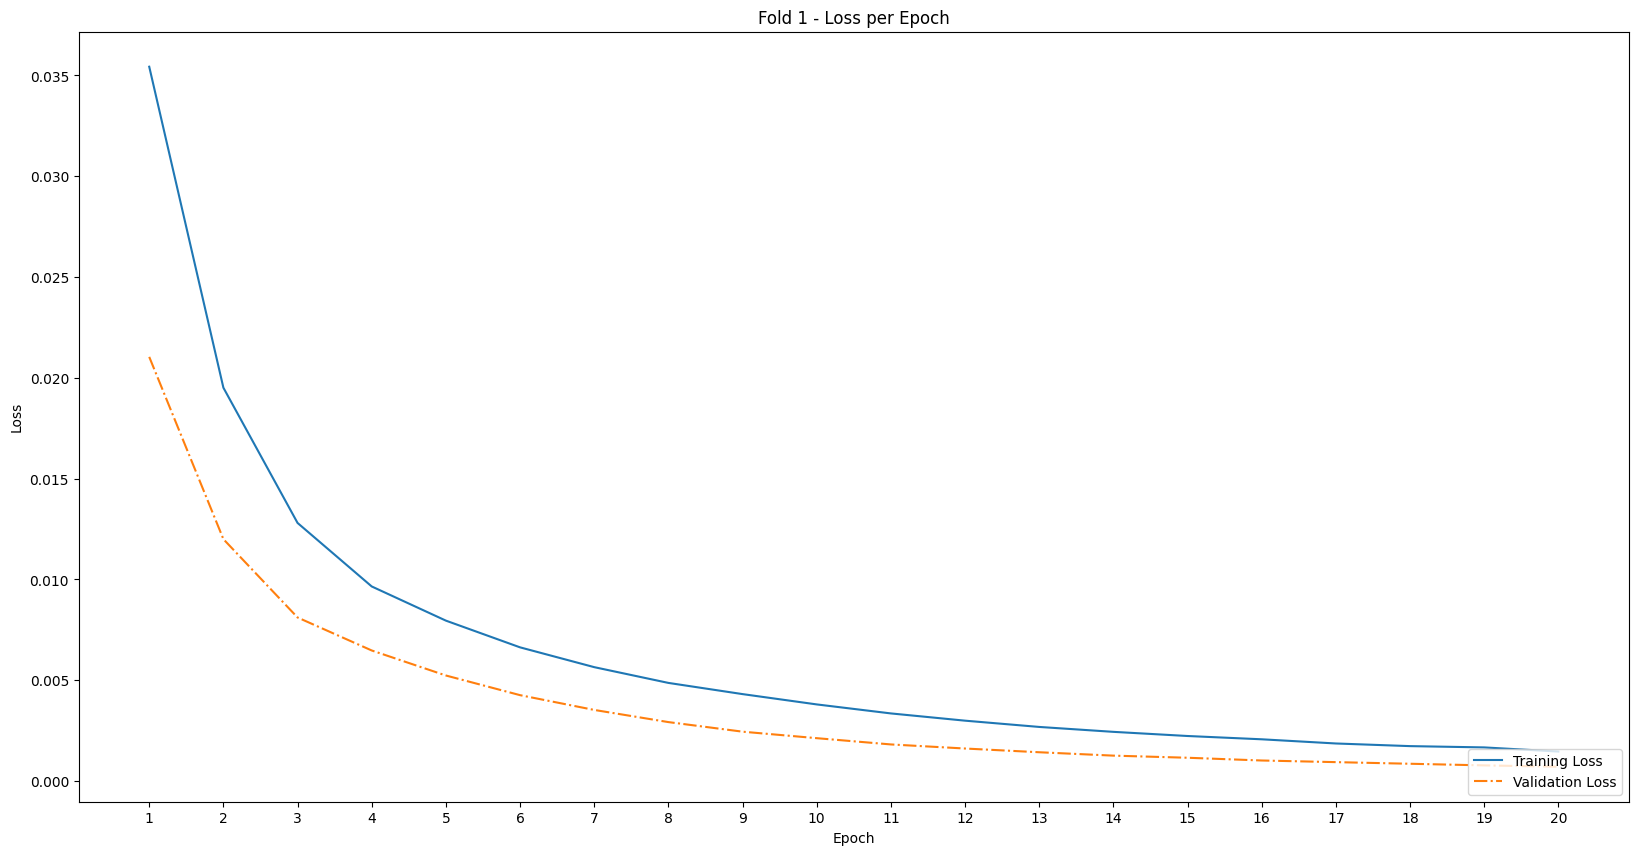

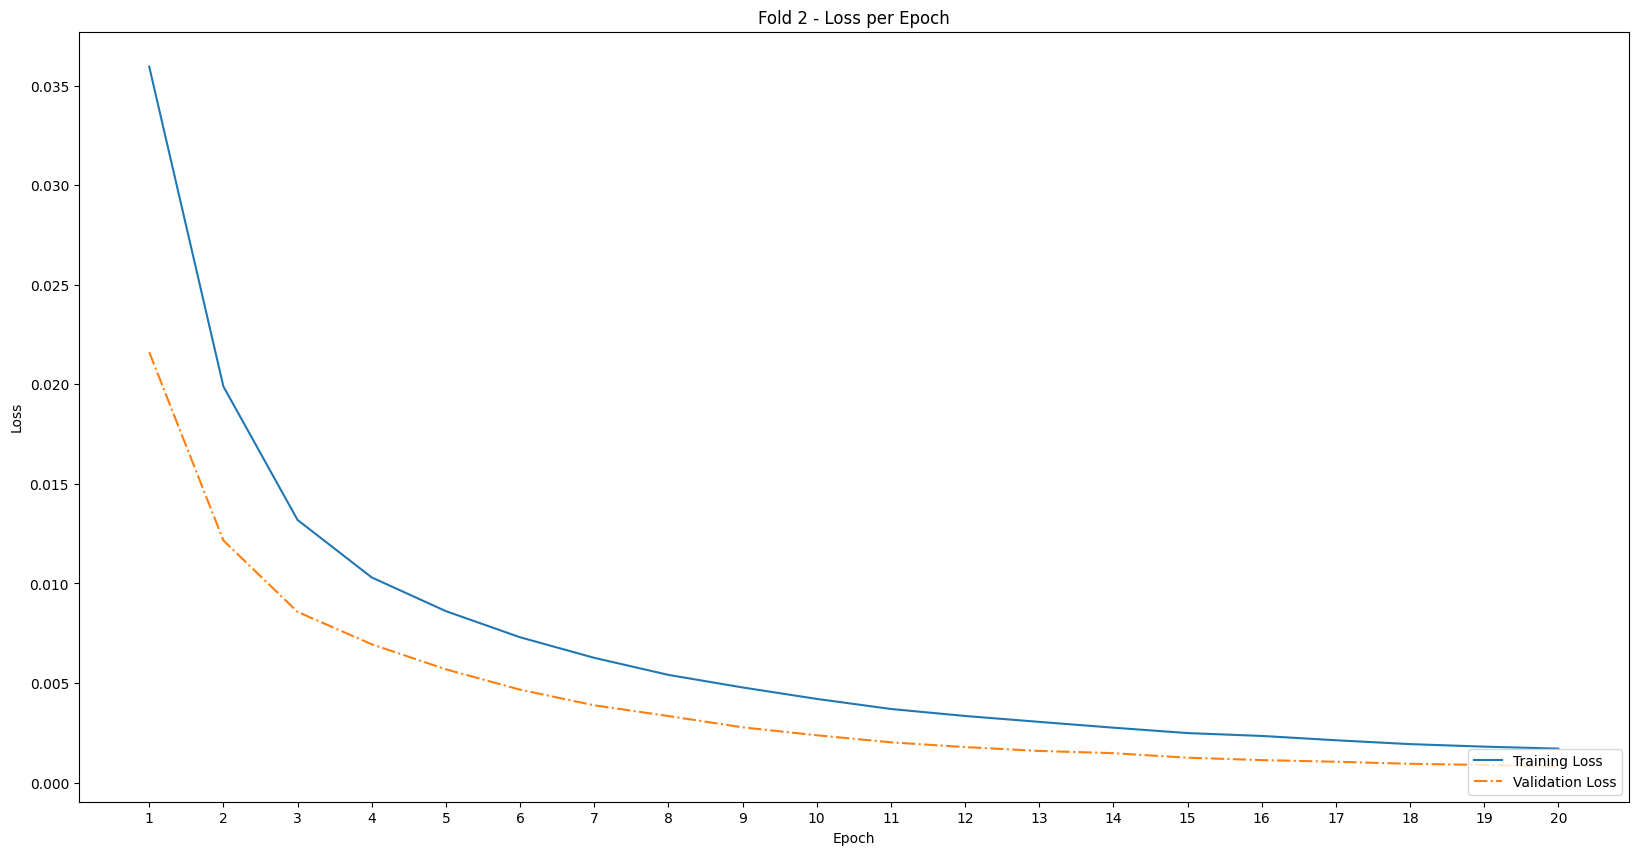

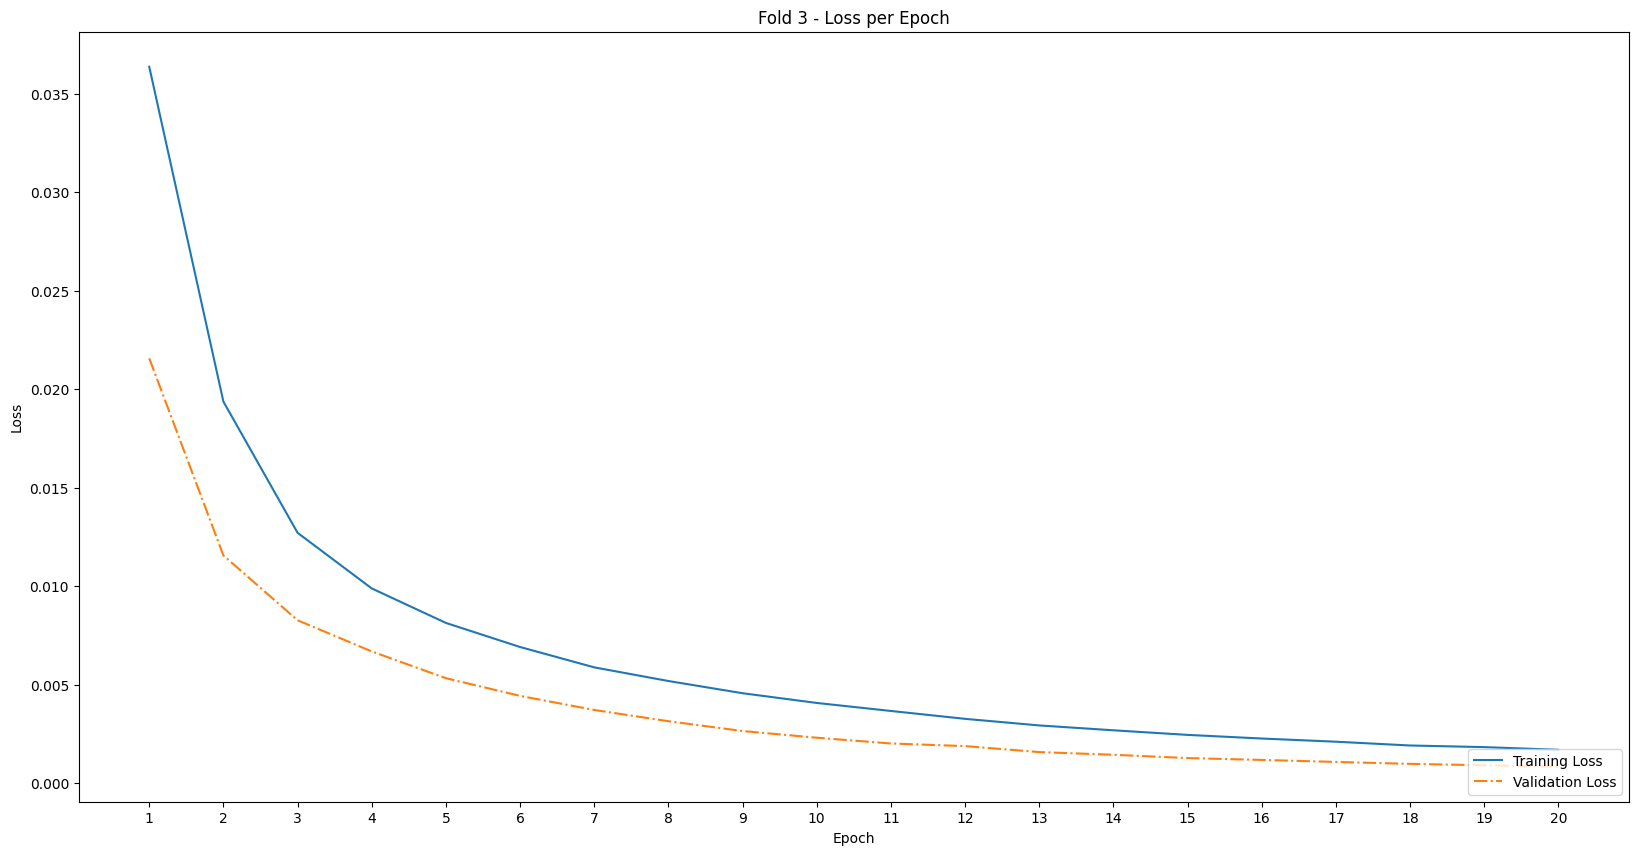

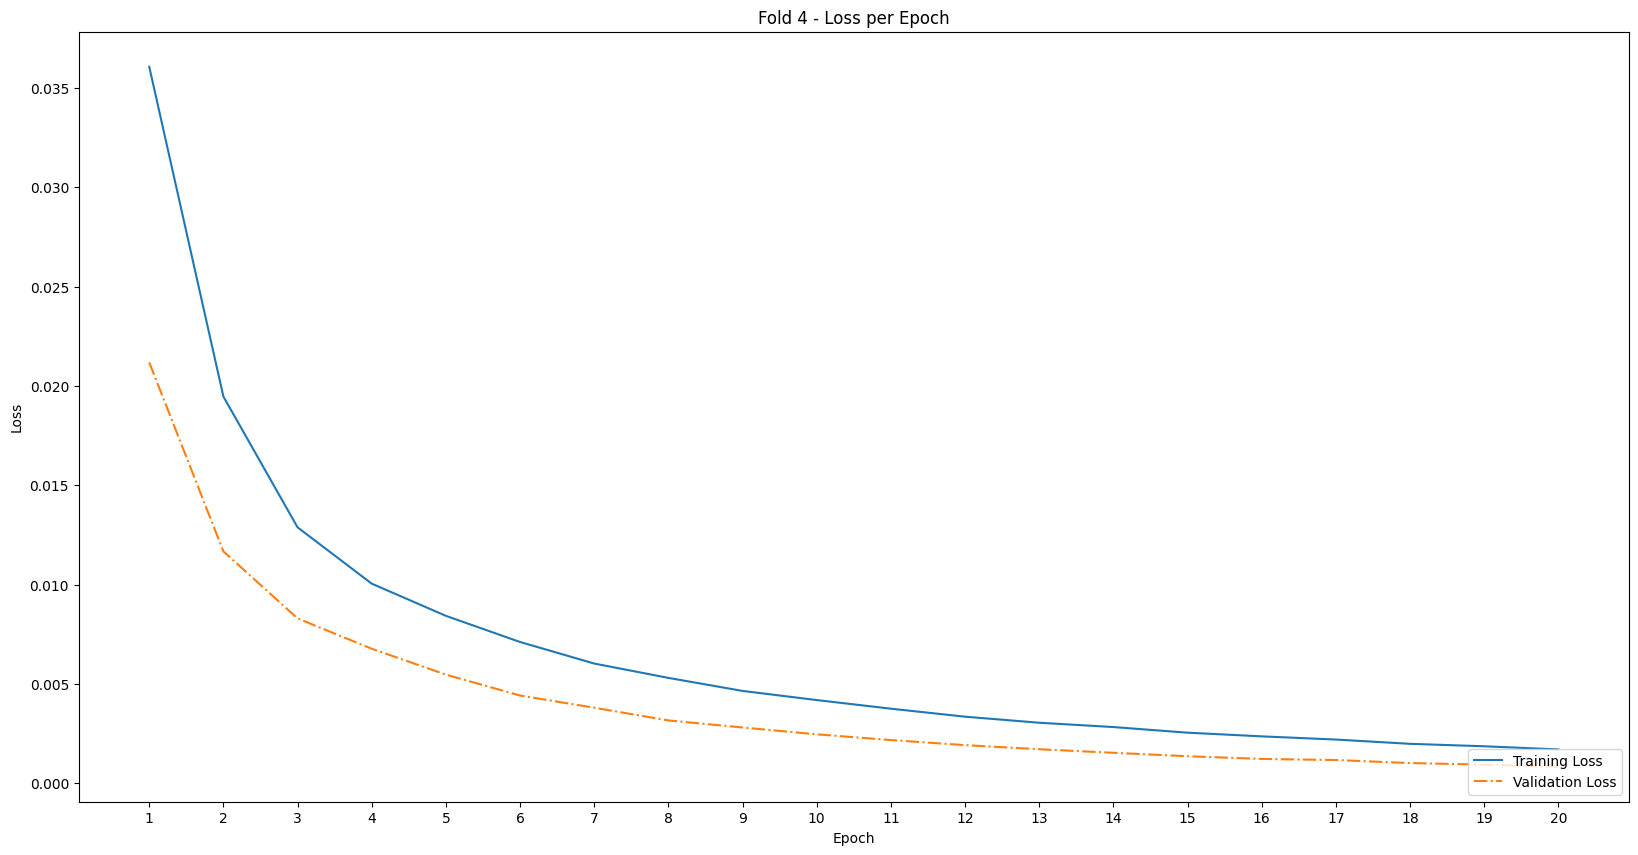

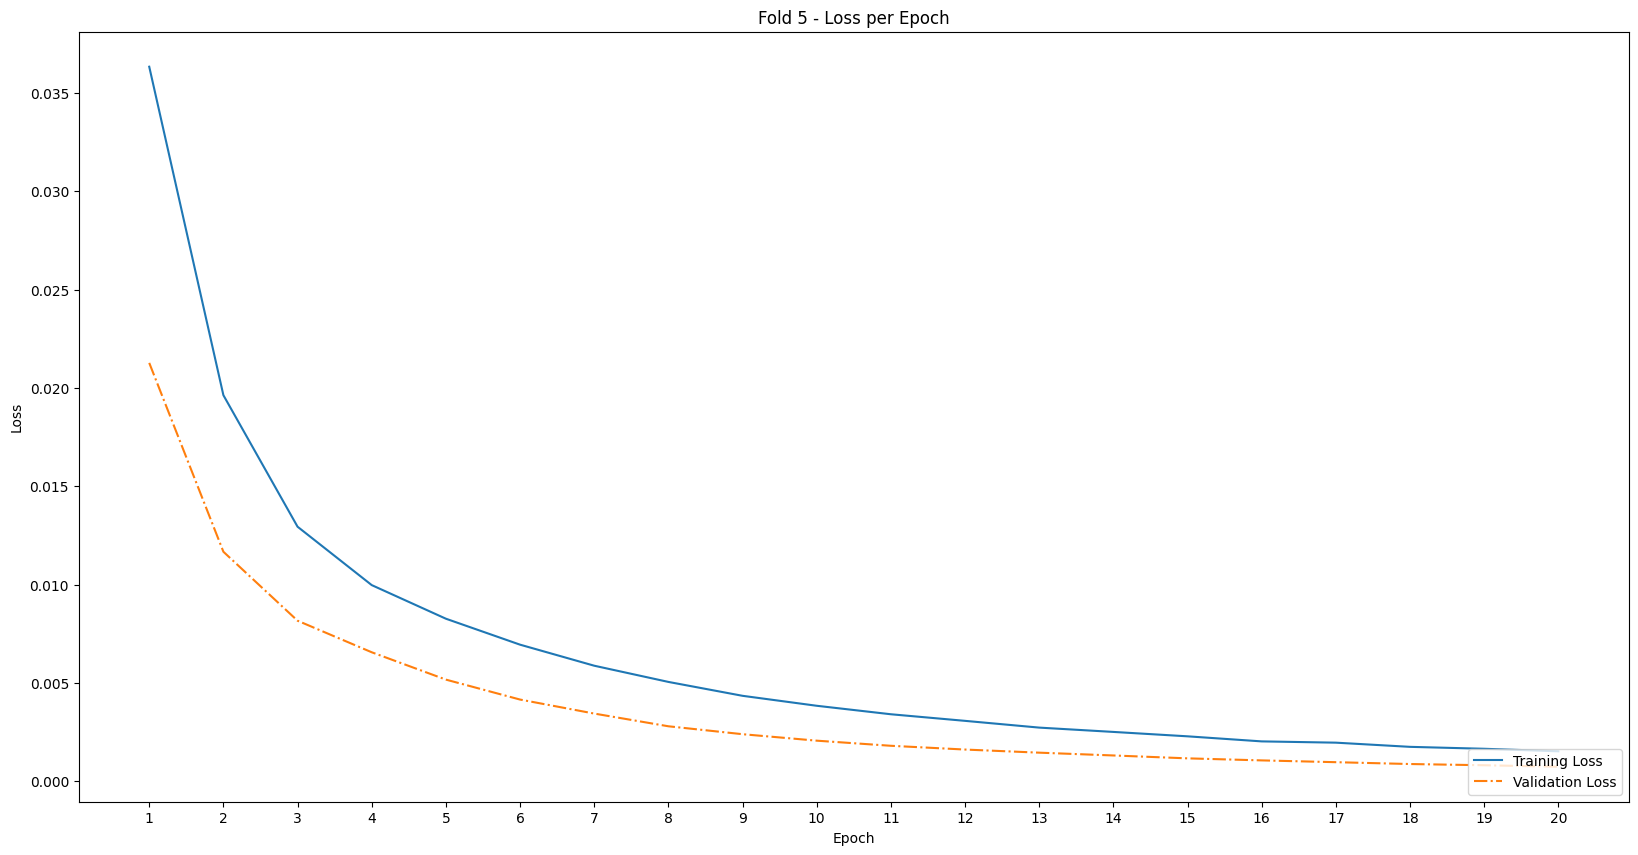

In [16]:
for i in range(5):
  x = np.arange(1, 21)
  y_train_loss = np.asarray(training_losses[i], dtype=np.float32)
  y_val_loss = np.asarray(validation_losses[i], dtype=np.float32)

  plt.figure(figsize=(20,10))

  plt.plot(x, y_train_loss[0:20])
  plt.plot(x, y_val_loss[0:20], '-.')

  plt.xticks(np.arange(min(x), max(x)+1, 1.0))
  plt.legend(["Training Loss", "Validation Loss"], loc="lower right")

  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f'Fold {i + 1} - Loss per Epoch')
  plt.show()

### Save Model

In [ ]:
# save_path = 'model/class/'
# !mkdir -p model/class/

# model_class_path = os.path.join(save_path, "melayubert_class_tesaurus"+".pth")

# model.to('cpu')
# torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Test


Average loss di testing data: 0.0007207033003385493


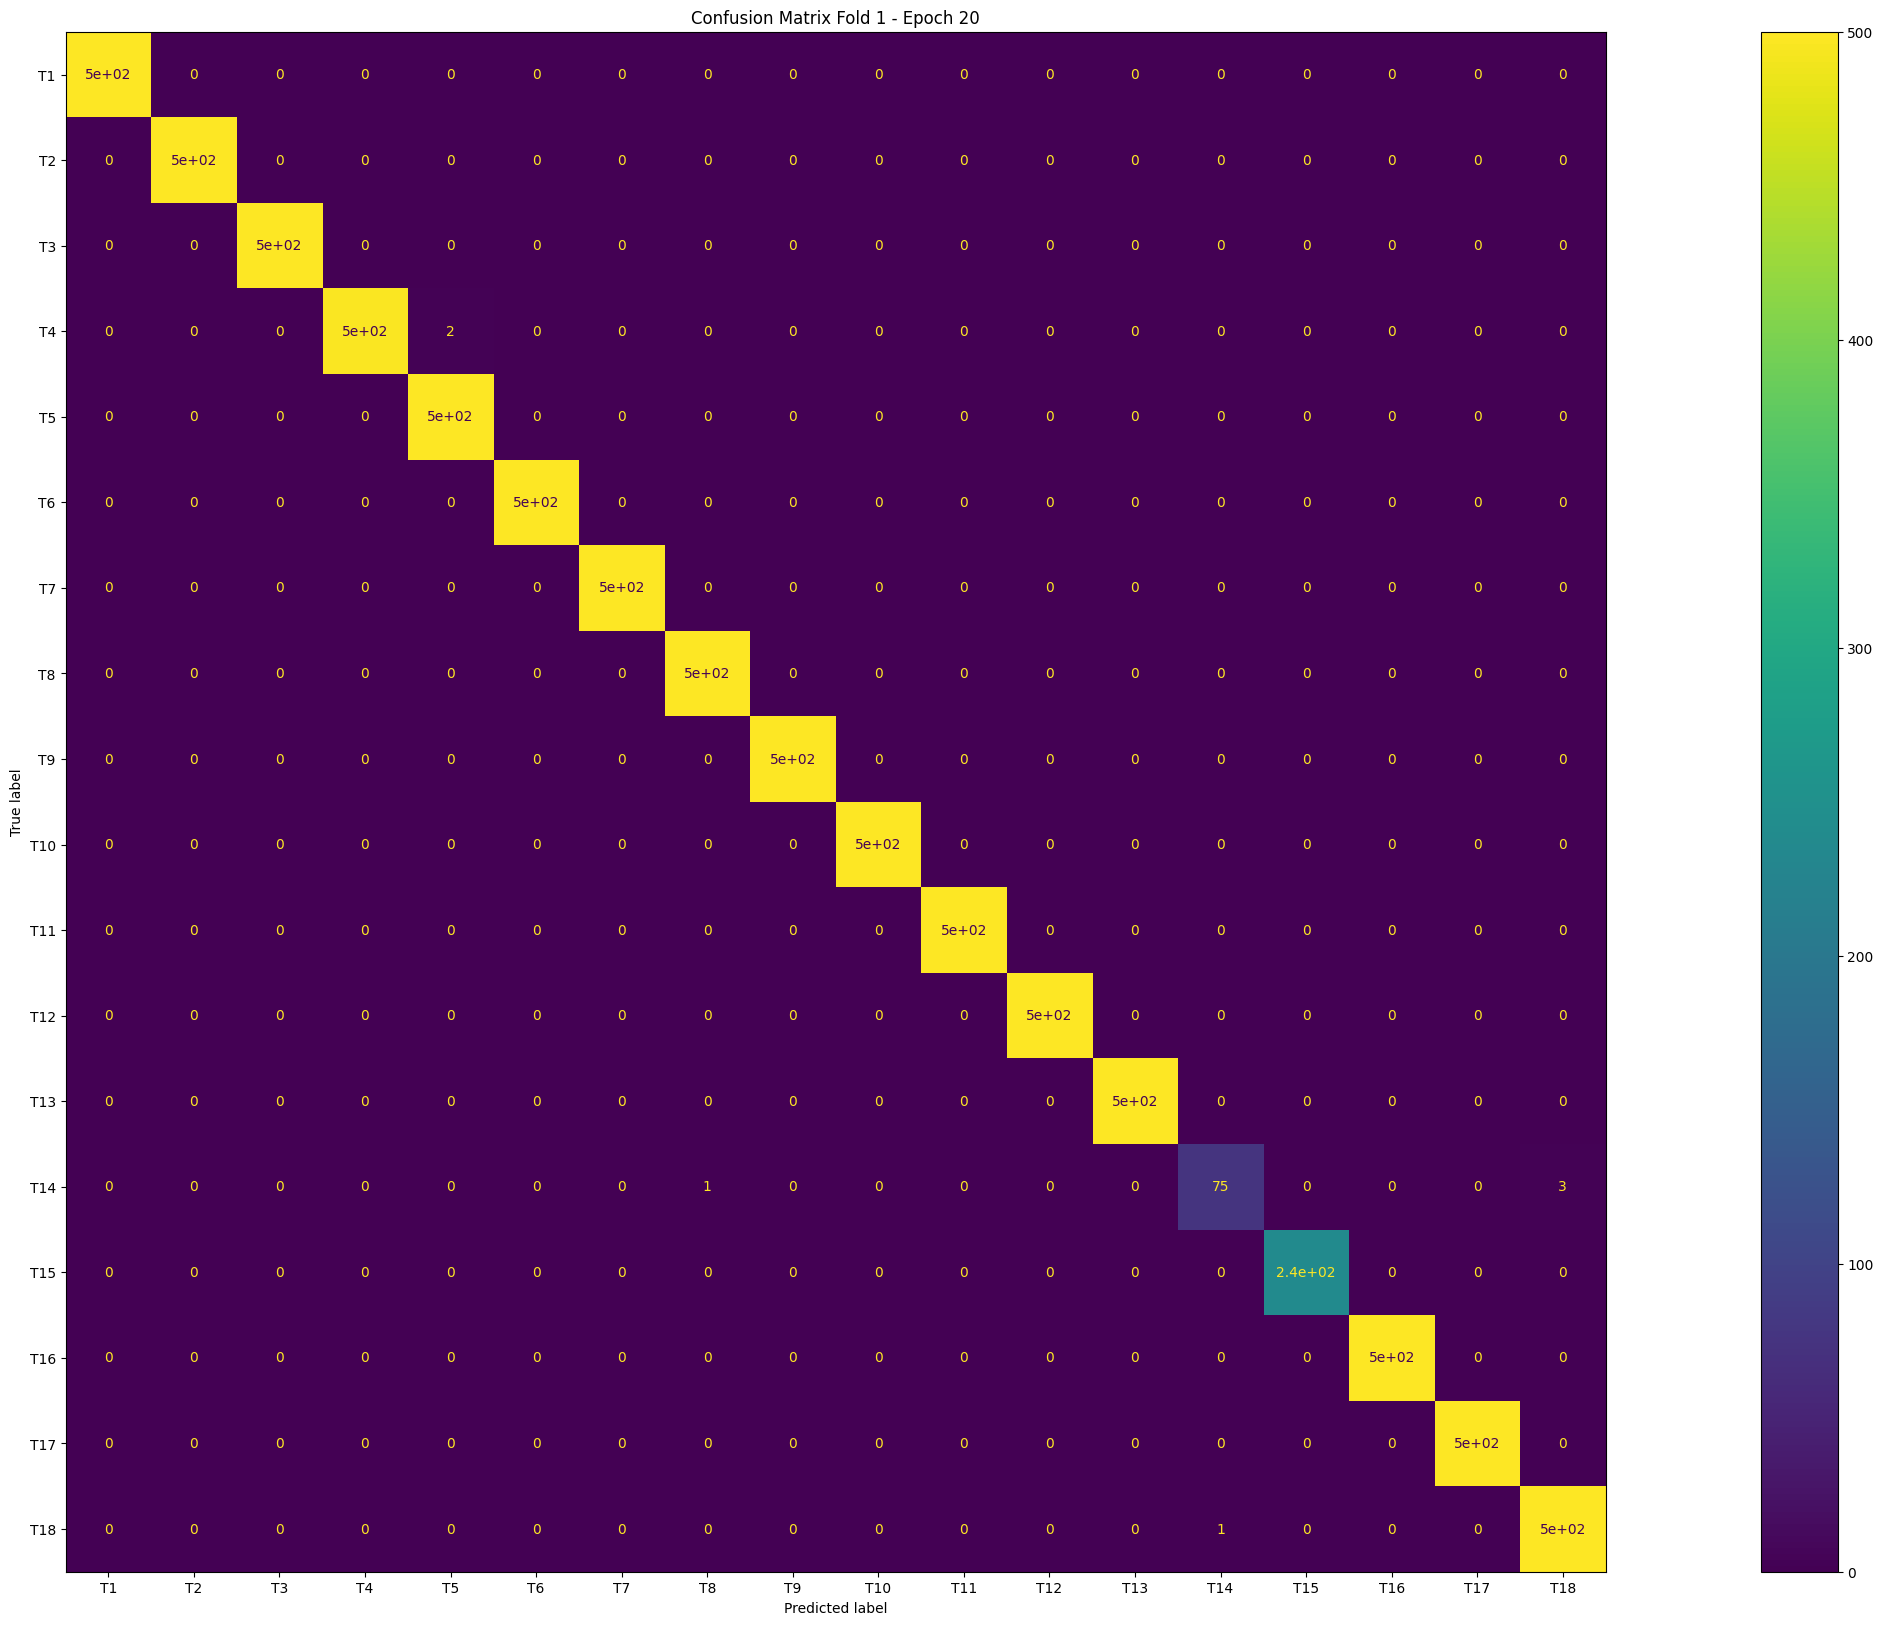

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,0.996000,1.000000,0.996000,0.997996
T5,500.0,1.000000,0.996016,1.000000,0.998004
T6,500.0,1.000000,1.000000,1.000000,1.000000
T7,500.0,1.000000,1.000000,1.000000,1.000000
T8,500.0,1.000000,0.998004,1.000000,0.999001
T9,500.0,1.000000,1.000000,1.000000,1.000000
T10,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 0.0008155395458003425


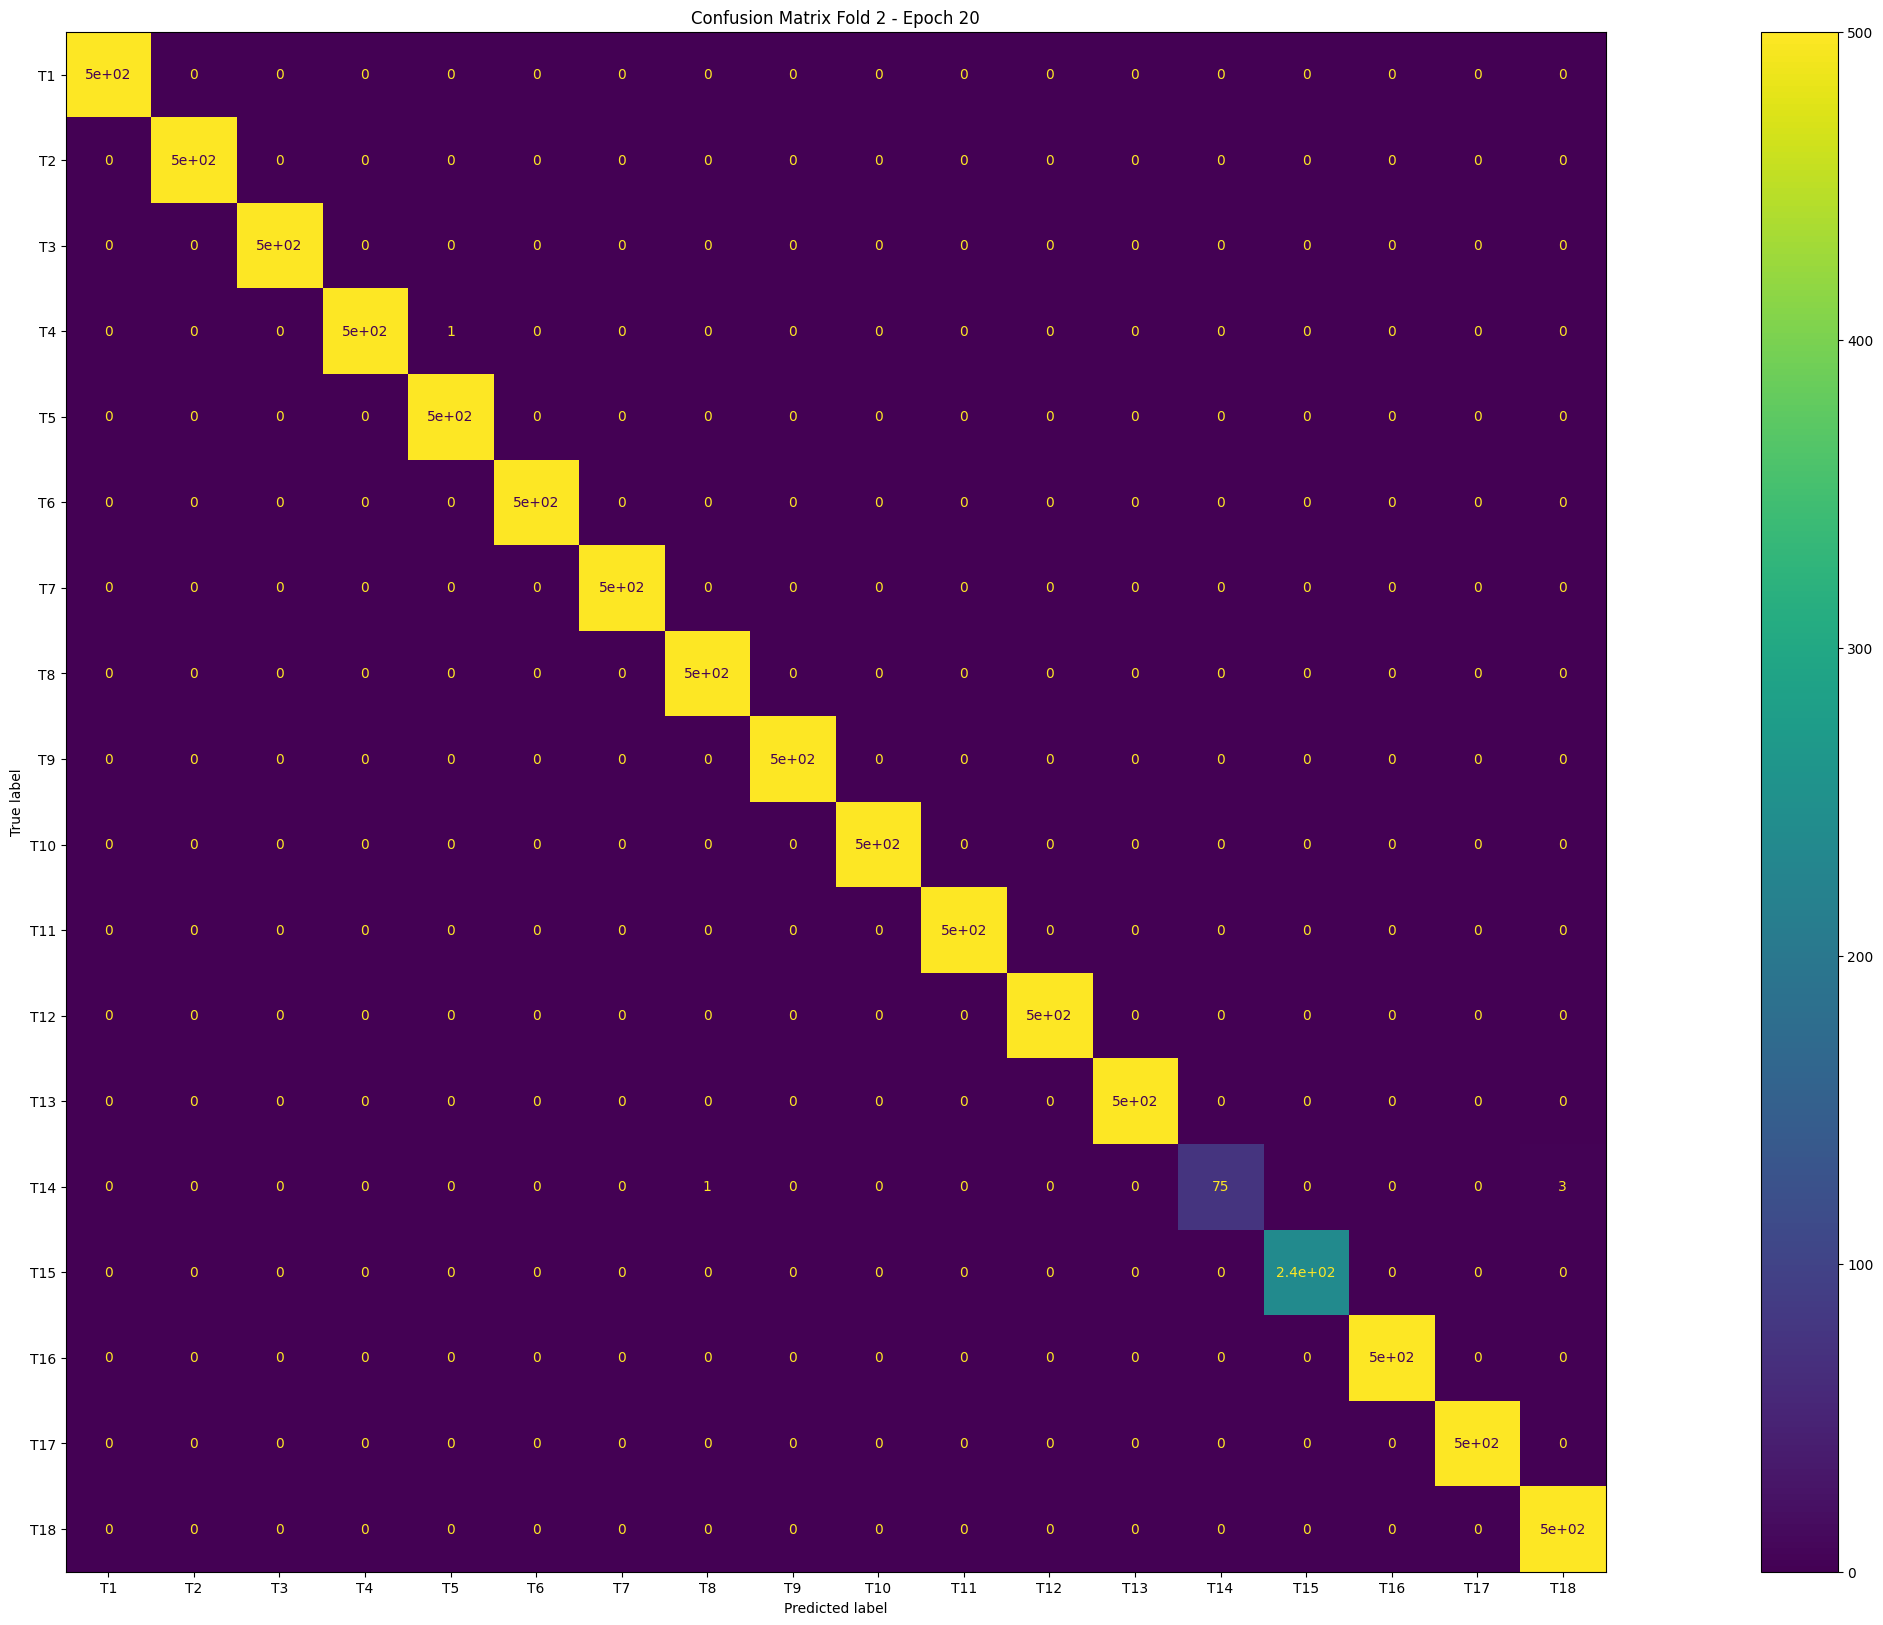

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,0.998000,1.000000,0.998000,0.998999
T5,500.0,1.000000,0.998004,1.000000,0.999001
T6,500.0,1.000000,1.000000,1.000000,1.000000
T7,500.0,1.000000,1.000000,1.000000,1.000000
T8,500.0,1.000000,0.998004,1.000000,0.999001
T9,500.0,1.000000,1.000000,1.000000,1.000000
T10,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 0.0008474144082311312


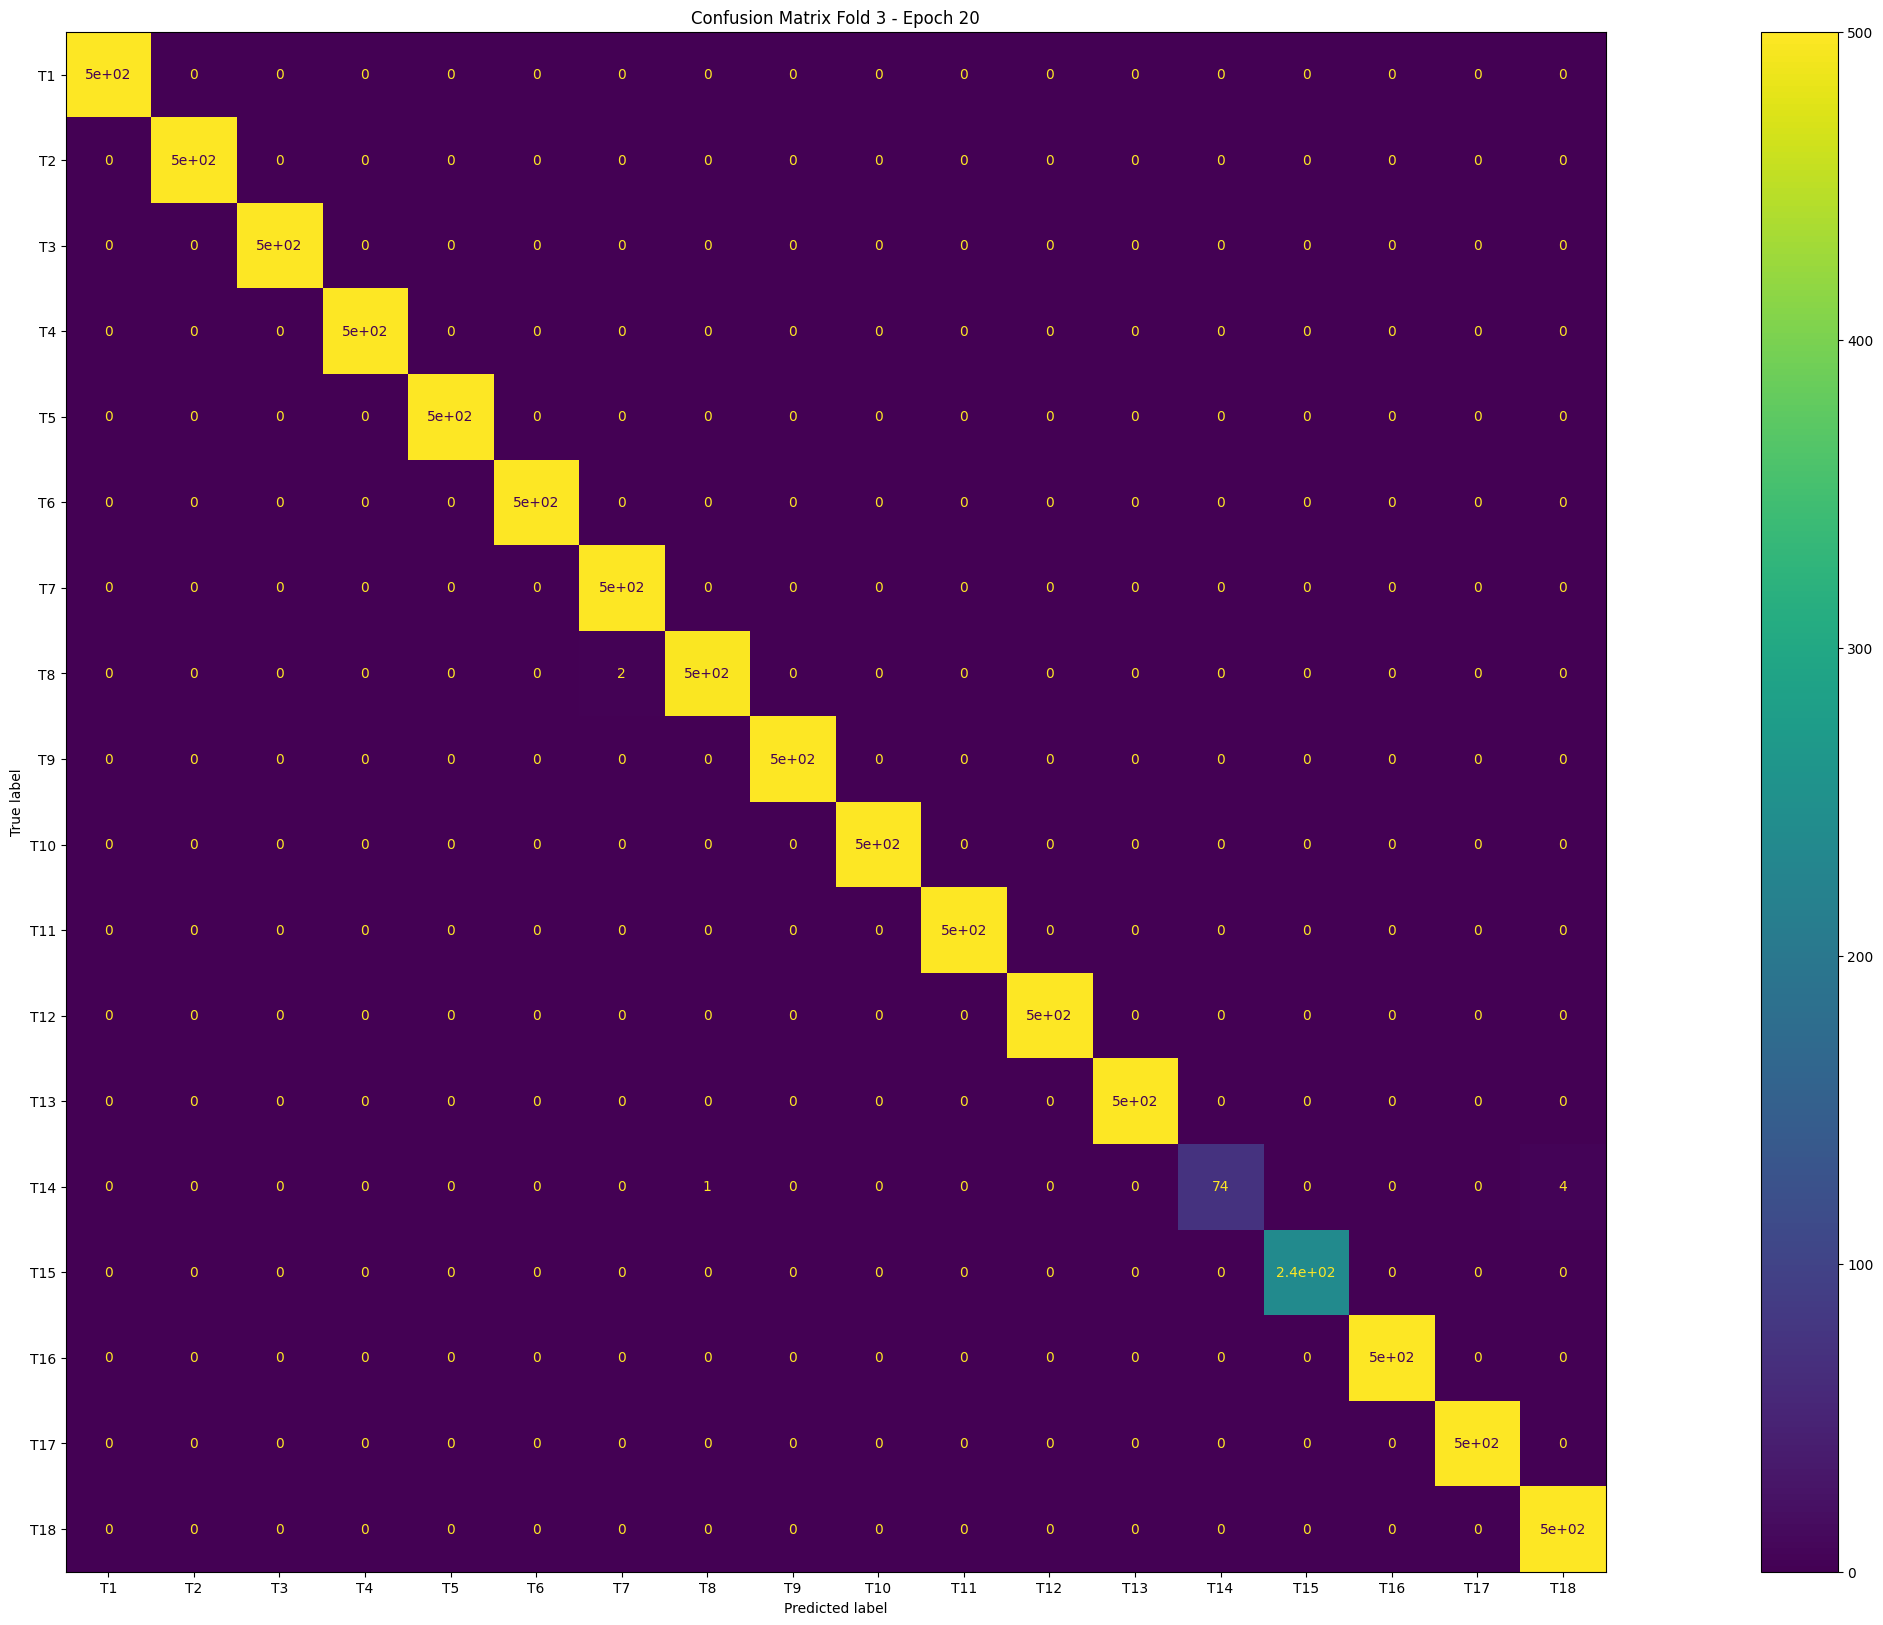

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,1.000000,1.000000,1.000000,1.000000
T5,500.0,1.000000,1.000000,1.000000,1.000000
T6,500.0,1.000000,1.000000,1.000000,1.000000
T7,500.0,1.000000,0.996016,1.000000,0.998004
T8,500.0,0.996000,0.997996,0.996000,0.996997
T9,500.0,1.000000,1.000000,1.000000,1.000000
T10,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 0.000847859892579448


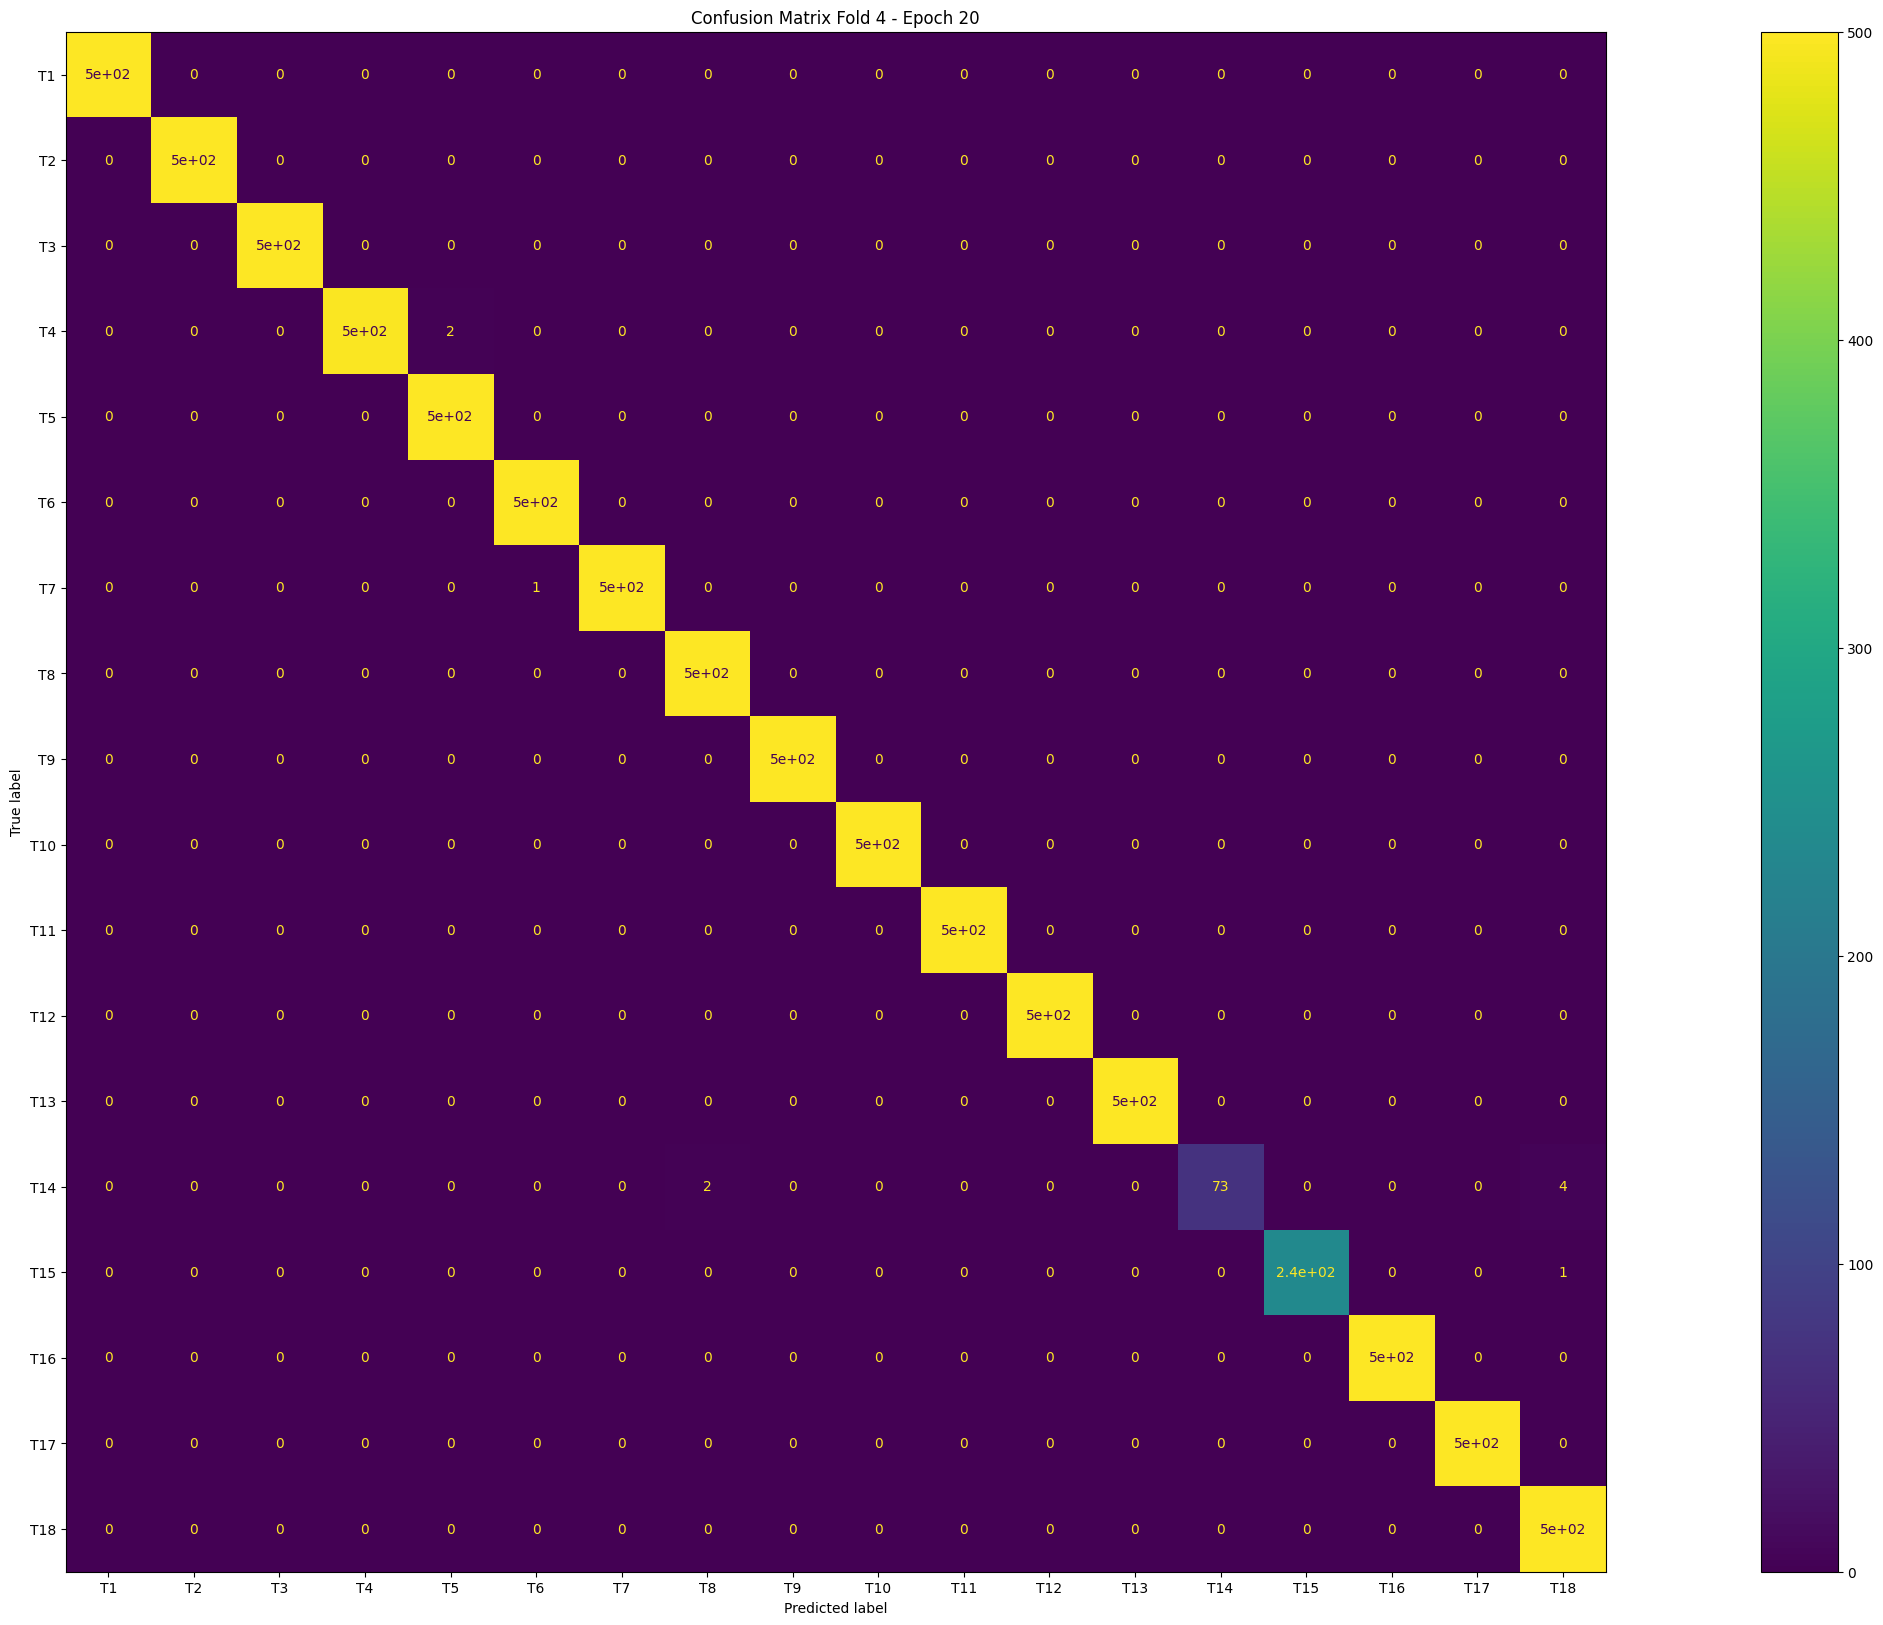

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,0.996000,1.000000,0.996000,0.997996
T5,500.0,1.000000,0.996016,1.000000,0.998004
T6,500.0,1.000000,0.998004,1.000000,0.999001
T7,500.0,0.998000,1.000000,0.998000,0.998999
T8,500.0,1.000000,0.996016,1.000000,0.998004
T9,500.0,1.000000,1.000000,1.000000,1.000000
T10,500.0,1.000000,1.000000,1.000000,1.000000



Average loss di testing data: 0.0007471280017060194


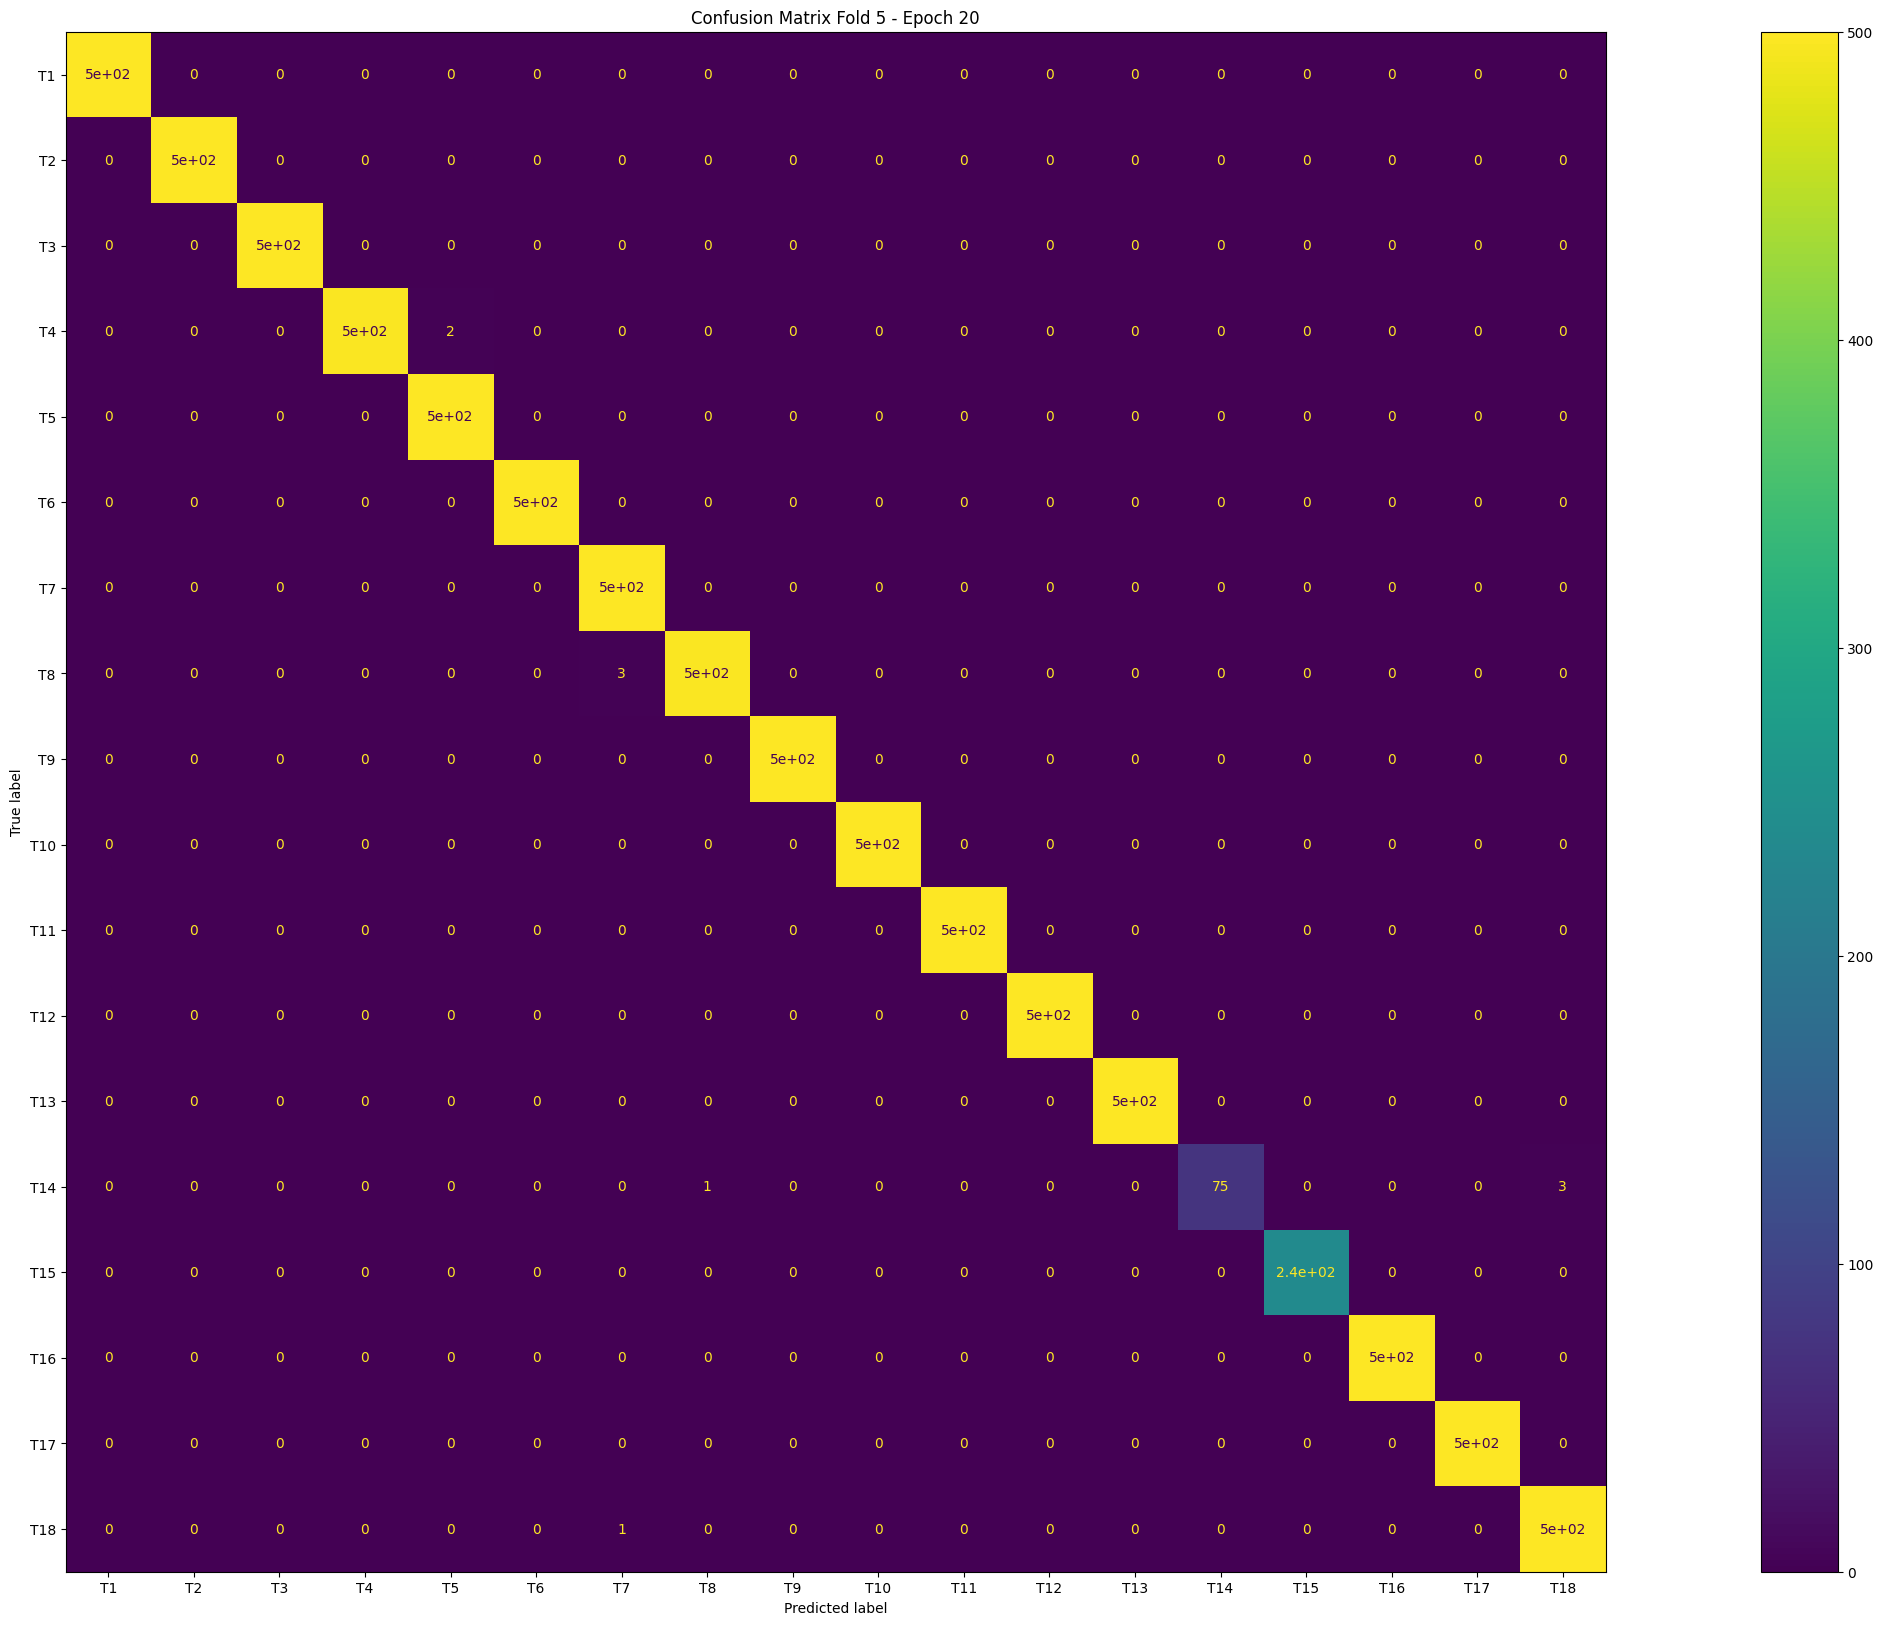

,Amount of Data,Accuracy,Precision,Recall,F One
T1,500.0,1.000000,1.000000,1.000000,1.000000
T2,500.0,1.000000,1.000000,1.000000,1.000000
T3,500.0,1.000000,1.000000,1.000000,1.000000
T4,500.0,0.996000,1.000000,0.996000,0.997996
T5,500.0,1.000000,0.996016,1.000000,0.998004
T6,500.0,1.000000,1.000000,1.000000,1.000000
T7,500.0,1.000000,0.992063,1.000000,0.996016
T8,500.0,0.994000,0.997992,0.994000,0.995992
T9,500.0,1.000000,1.000000,1.000000,1.000000
T10,500.0,1.000000,1.000000,1.000000,1.000000


In [17]:
for fold_i in range(5):

  tr_loss = 0

  save_path = 'model_melayubert/class_tesaurus_checkpoint/fold_' + str(fold_i)
  model_class_path = os.path.join(save_path, "melayubert_class_tesaurus_checkpoint_19.pth")
  model = torch.load(model_class_path)

  model.to(DEVICE)

  model.eval()

  nb_classes = 18

  true_recaps = [[] for i in range(5)]
  false_recaps = [[] for i in range(5)]

  conf_matrix = torch.zeros(nb_classes, nb_classes)
  # Untuk setiap data di training data
  for data in test_instances:

    with torch.no_grad():
      # Mendapatkan output dari model
      input, gold = data
      input = input.to(DEVICE)
      gold = gold.to(DEVICE)
      pred = model(input)

      # Categorical Cross-Entropy --- Loss Function
      loss = loss_func(pred, gold)
      # _, pred = torch.max(pred, 1)
        # for t, p in zip(gold.view(-1), pred.view(-1)):
        #   confusion_matrix[t.long(), p.long()] += 1

      # akumulasi loss dalam 1 epoch
      tr_loss += loss.item()

      conf_matrix = confusion_matrix(gold, pred, conf_matrix)

      for input_recap, gold_recap, pred_recap in zip(input.to('cpu'), gold.to('cpu'), pred.to('cpu')):
        input_recap_sentence = tokenizer.decode(input_recap)
        _, gold_idx = torch.max(gold_recap, 0)
        _, pred_idx = torch.max(pred_recap, 0)
        if gold_idx == pred_idx:
          true_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))
        else:
          false_recaps[fold_i].append((input_recap_sentence, gold_idx, pred_idx))

  amt, acc, prec, rec, f1 = evaluation_metric(conf_matrix)
  data_conf = {
          'Amount of Data': amt,
          'Accuracy': acc,
          'Precision': prec,
          'Recall': rec,
          'F One': f1
      }

  # rata-rata loss dalam 1 epoch
  avg_loss = tr_loss / test_size
  # accuracy = confusion_matrix.diag()/confusion_matrix.sum(1)

  print("")
  print(f"Average loss di testing data: {avg_loss}")

  fig, ax = plt.subplots(figsize=(40, 20))

  display_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18']
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix.detach().cpu().numpy(), display_labels=display_labels)
  disp.plot(ax=ax)
  plt.title(f"Confusion Matrix Fold {fold_i + 1} - Epoch 20")

  plt.show()

  disp_df = pd.DataFrame(data=data_conf,
                          index=display_labels, columns=['Amount of Data', 'Accuracy', 'Precision', 'Recall', 'F One'])
  display(disp_df)

In [18]:
save_path = 'model_melayubert/class_tesaurus_checkpoint/fold_0'
model_class_path = os.path.join(save_path, "melayubert_class_tesaurus_checkpoint_19.pth")
model = torch.load(model_class_path)

# bert_class = model_class

save_path = 'model/class/'
!mkdir -p model/class/
model_class_path = os.path.join(save_path, "melayubert_class_tesaurus"+".pth")

model.to('cpu')
torch.save(model, model_class_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
df_true_recaps = pd.DataFrame(true_recaps[0], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_true_recaps.to_csv('dataset/melayubert_classification_true_recaps.csv', index=False)

In [20]:
df_false_recaps = pd.DataFrame(false_recaps[0], columns=['question', 'true_label', 'pred_label'])

save_path = 'dataset/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
df_false_recaps.to_csv('dataset/melayubert_classification_false_recaps.csv', index=False)